In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict

from collections import Counter

import re
from langdetect import detect


from pymorphy2 import MorphAnalyzer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

from itertools import chain

import json

In [2]:
hh_df = pd.read_excel('data/hh_all_IT_53052_vacancies_with_text_08062025.xlsx')

In [3]:
hh_other_df = pd.read_excel('data/hh_Drugie.xlsx')

In [4]:
# приводим к одному словарю признаков

column_mapping = {
    'Название': 'vacancy',
    'Компания': 'company',
    'Город': 'city',
    'Опыт': 'experience',
    'Занятость': 'employment',
    'График': 'schedule',
    'Зарплата от': 'salary from',
    'Зарплата до': 'salary to',
    'Валюта': 'currency',
    'Ключевые навыки': 'skills',
    'URL': 'url',
    'Дата публикации': 'date',
    #'Уровень специалиста': 'level',
    #'требования': 'requirements',
    #'обязанности': 'responsibilities',
    'professional_role': 'position'
}

# Переименовываем столбцы
hh_other_df = hh_other_df.rename(columns=column_mapping)

hh_other_df= hh_other_df.drop(['ID','Формат работы'], axis = 1)

In [5]:
superjob_df = pd.read_csv('data/superjob_2.csv')

In [6]:
superjob_df = superjob_df.drop('Unnamed: 0', axis = 1)

In [7]:
geekjobs_df = pd.read_csv('data/results_geekjob.csv')
theyseeku_df = pd.read_csv('data/results_finder.csv')

In [8]:
import re

def clean_text(text):
    # Приводим к строке, удаляем все пробелы и невидимые символы, включая переносы строк
    text = str(text)
    text = re.sub(r'\s+', '', text)  # Удаляем ВСЕ пробелы, переносы и табы
    text = text.lower()              
    return text

# Сравниваем очищенные версии столбцов
(geekjobs_df['text'].apply(clean_text) == geekjobs_df['skills'].apply(clean_text)).sum()

586

In [9]:
# Сравниваем очищенные версии столбцов
(theyseeku_df['text'].apply(clean_text) == theyseeku_df['skills'].apply(clean_text)).sum()

0

In [10]:
# Объединяем все  DataFrame по строкам
data = pd.concat([hh_other_df, hh_df, superjob_df, theyseeku_df], ignore_index=True, join='outer')

In [11]:
# дубликаты
columns_to_check = [col for col in data.columns if col != 'date']
duplicates = data[data.duplicated(subset=columns_to_check, keep='first')]
print(f"Найдено дубликатов: {len(duplicates)}")

data = data.drop(duplicates.index, axis = 0 )

Найдено дубликатов: 5


In [12]:
# Функция для очистки и преобразования зарплат


def clean_salary(salary):
    if pd.isna(salary) or salary == '' or salary == 'не указана':
        return np.nan
    
    # Если строка, очищаем от лишних символов
    if isinstance(salary, str):
        # Удаляем пробелы между цифрами (например '140 000' -> '140000')
        salary = salary.replace(' ', '')
        # Удаляем нечисловые символы (кроме точки)
        salary = ''.join(c for c in salary if c.isdigit() or c == '.' or c == '-')
        # Обработка значений типа '90k' (предполагаем, что k означает тысячи)
        if 'k' in salary.lower():
            salary = salary.lower().replace('k', '')
            try:
                return float(salary) * 1000
            except:
                return np.nan
    
    try:
        return float(salary)
    except:
        return np.nan
        


In [13]:
cleaned_data = data.copy()

In [14]:
cleaned_data[cleaned_data['position'] == 'Гейм-дизайнер']['skills']

84                            Монетизация игр, Гейм-дизайн
85       Английский язык, Atlassian Jira, Atlassian Con...
86       Английский язык, Atlassian Jira, Atlassian Con...
87                          Unreal Engine, 3C, Game Design
88                          Unreal Engine, Game Design, AI
                               ...                        
15308                                                  NaN
15309                                                  NaN
15310                                         Android, iOS
15311                                                  NaN
15312                                                  NaN
Name: skills, Length: 227, dtype: object

In [15]:
# Применяем функцию очистки к столбцам с зарплатами
cleaned_data['salary from'] = cleaned_data['salary from'].apply(clean_salary)
cleaned_data['salary to'] = cleaned_data['salary to'].apply(clean_salary)

# подстановка занчений from / to  от соседа

cleaned_data['salary from'] = cleaned_data['salary from'].fillna(cleaned_data['salary to'])
cleaned_data['salary to'] = cleaned_data['salary to'].fillna(cleaned_data['salary from'])

In [16]:
cleaned_data = cleaned_data.drop('employment.1', axis =1)

In [17]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59243 entries, 0 to 59247
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   position          53703 non-null  object 
 1   date              54223 non-null  object 
 2   vacancy           59243 non-null  object 
 3   company           59243 non-null  object 
 4   city              59243 non-null  object 
 5   experience        51619 non-null  object 
 6   employment        58674 non-null  object 
 7   schedule          55355 non-null  object 
 8   salary from       24255 non-null  float64
 9   salary to         24255 non-null  float64
 10  currency          24255 non-null  object 
 11  skills            31930 non-null  object 
 12  url               59243 non-null  object 
 13  ID                53052 non-null  float64
 14  country           7591 non-null   object 
 15  industry          45461 non-null  object 
 16  text              58584 non-null  object 
 17

In [18]:
df =cleaned_data.copy()

#### Исследуем Skills в разрезе position

In [19]:
df['position'].value_counts()

position
Программист, разработчик                        12147
Специалист технической поддержки                 6154
Руководитель проектов                            4481
Дизайнер, художник                               4006
Системный администратор                          3856
Аналитик                                         3722
Специалист по информационной безопасности        3001
Менеджер продукта                                2156
Тестировщик                                      1900
Бизнес-аналитик                                  1588
Системный аналитик                               1470
BI-аналитик, аналитик данных                     1359
DevOps-инженер                                   1234
Руководитель группы разработки                    959
Сетевой инженер                                   929
Системный инженер                                 925
Методолог                                         867
Дата-сайентист                                    683
Технический директо

In [20]:
df['position'].value_counts().count()

25

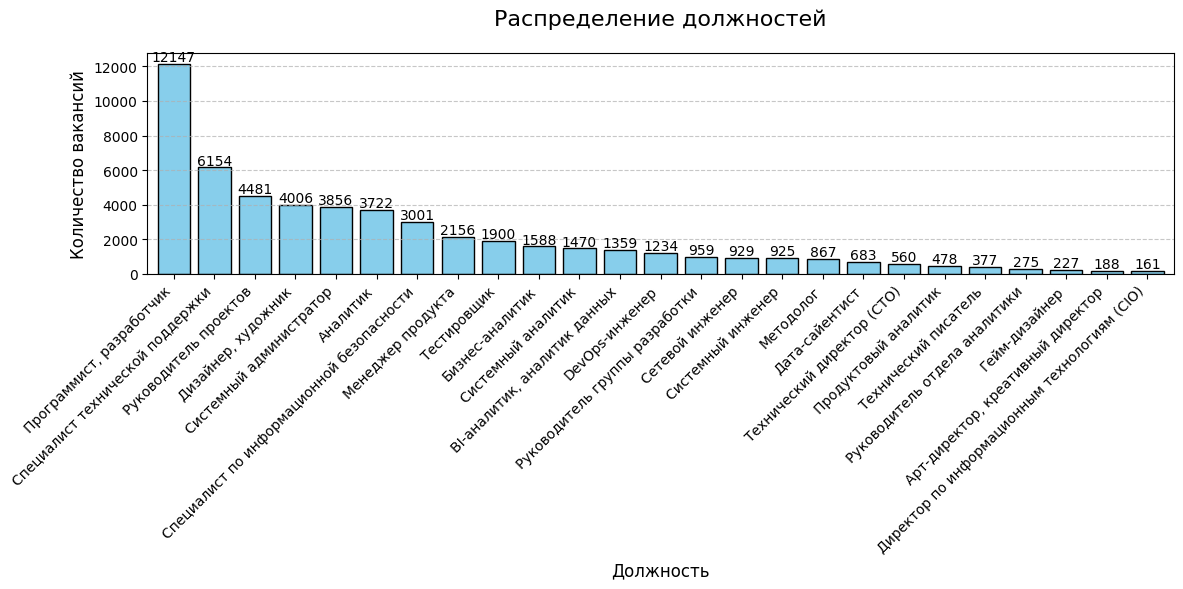

In [21]:
import matplotlib.pyplot as plt

# Получаем частотное распределение
position_counts = df['position'].value_counts()

# Создаем график
plt.figure(figsize=(12, 6))

# Бар-чарт с настройками
ax = position_counts.plot(kind='bar', 
                         color='skyblue',
                         edgecolor='black',
                         width=0.8)

# Настройки оформления
plt.title('Распределение должностей', fontsize=16, pad=20)
plt.xlabel('Должность', fontsize=12)
plt.ylabel('Количество вакансий', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Добавляем подписи значений
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

#### Начало работы со skills

In [22]:
df['skills']

0                                                      NaN
1        SQL, analyst, SDLC, Software Development, Paym...
2        Исследовательский анализ данных, Визуализация ...
3        Analysis, API, MS Excel, Power BI, Tableau, An...
4                                             SQL, Tableau
                               ...                        
59243                                                  NaN
59244                                                  NaN
59245                                                  NaN
59246                                                  NaN
59247                                                  NaN
Name: skills, Length: 59243, dtype: object

In [23]:
from ast import literal_eval

#Преобразование skills в список
df['skills'] = df['skills'].apply(lambda x: [s.strip() for s in str(x).split(',')] if pd.notna(x) else [])

In [ ]:


positions = df['position'].value_counts().index

#Создаем графики для каждой профессии
for position in positions:
    # Фильтруем по профессии и собираем все навыки
    skills_flat = [skill for sublist in df[df['position'] == position]['skills'] for skill in sublist]
    
    if not skills_flat:
        continue
        
    # Считаем частоту навыков
    skills_counts = pd.Series(skills_flat).value_counts().head(30)
    
    # Создаем график
    plt.figure(figsize=(12, 6))
    skills_counts.sort_values().plot(kind='barh', color='skyblue')
    plt.title(f'Топ-30 навыков для {position}\n(Всего вакансий: {len(df[df["position"]==position])})')
    plt.xlabel('Количество упоминаний')
    plt.tight_layout()
    plt.show()

In [24]:
# Функция для очистки пустых списков
def clean_skills(skill_data):
    if isinstance(skill_data, list):
        if len(skill_data) == 0:  # Пустой список []
            return np.nan
        if len(skill_data) == 1 and isinstance(skill_data[0], list) and len(skill_data[0]) == 0:  # Список с пустым списком [[]]
            return np.nan
    return skill_data

# Применяем очистку
df['skills_cleaned'] = df['skills'].apply(clean_skills)

In [ ]:


# Создаем простую статистику
stats = pd.DataFrame({
    'Категория': ['Всего вакансий', 
                 'С skills (не пустые)', 
                 'Пустые skills (преобразованы в NaN)', 
                 'Без skills (изначально NaN)'],
    'Количество': [len(df),
                  df['skills_cleaned'].notna().sum(),
                  len(df) - df['skills_cleaned'].notna().sum() - df['skills'].isna().sum(),
                  df['skills'].isna().sum()]
})

print("Статистика после очистки:")
print(stats)

# Визуализация
fig = px.bar(stats, 
             x='Категория', 
             y='Количество',
             title='Распределение skills после очистки',
             text='Количество',
             color='Категория')

fig.update_layout(showlegend=False)
fig.show()

Статистика после очистки:
                             Категория  Количество
0                       Всего вакансий       59243
1                 С skills (не пустые)       31930
2  Пустые skills (преобразованы в NaN)       27313
3          Без skills (изначально NaN)           0


c:\Users\Андрей\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\express\_core.py:1979: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [26]:
# Заменяем исходный столбец
df['skills'] = df['skills_cleaned']
# Удаляем временный столбец
df.drop('skills_cleaned', axis=1, inplace=True)

In [ ]:


# 1. Создаем данные для визуализации
stats = pd.DataFrame({
    'Категория': ['Всего вакансий', 'С position', 'Без position', 
                 'С skills', 'Без skills', 'С salary from', 'Без salary from'],
    'Количество': [len(df), df['position'].notna().sum(), df['position'].isna().sum(),
                 df['skills'].notna().sum(), df['skills'].isna().sum(),
                 df['salary from'].notna().sum(), df['salary from'].isna().sum()]
})

combo_stats = pd.DataFrame({
    'Категория': ['С position и skills', 'С position но без skills', 
                 'Без position но с skills', 'С position и salary from', 
                 'С position но без salary from', 'Без position и без salary from'],
    'Количество': [df[df['position'].notna()]['skills'].notna().sum(),
                  df[df['position'].notna()]['skills'].isna().sum(),
                  df[df['position'].isna()]['skills'].notna().sum(),
                  df[df['position'].notna()]['salary from'].notna().sum(),
                  df[df['position'].notna()]['salary from'].isna().sum(),
                  df[df['position'].isna()]['salary from'].isna().sum()]
})

# 2. Создаем интерактивную панель
fig = make_subplots(rows=2, cols=2, 
                   subplot_titles=('Заполненность полей (абсолютные значения)',
                                 'Заполненность полей (% от общего числа)',
                                 'Комбинации заполненных полей'))

# График 1: Абсолютные значения
fig.add_trace(
    go.Bar(x=stats['Категория'], y=stats['Количество'], 
           marker_color='#636EFA'),
    row=1, col=1
)

# График 2: Процентные значения
fig.add_trace(
    go.Bar(x=stats['Категория'], y=stats['Количество']/len(df)*100,
           marker_color='#EF553B'),
    row=1, col=2
)

# График 3: Комбинации
fig.add_trace(
    go.Bar(x=combo_stats['Категория'], y=combo_stats['Количество'],
           marker_color='#00CC96'),
    row=2, col=1
)

# Настройка внешнего вида
fig.update_layout(height=800, width=1000, 
                 title_text="Анализ заполненности данных", showlegend=False)
fig.update_xaxes(tickangle=45)
fig.show()

In [285]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59243 entries, 0 to 59247
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   position          53703 non-null  object 
 1   date              54223 non-null  object 
 2   vacancy           59243 non-null  object 
 3   company           59243 non-null  object 
 4   city              59243 non-null  object 
 5   experience        51619 non-null  object 
 6   employment        58674 non-null  object 
 7   schedule          55355 non-null  object 
 8   salary from       24255 non-null  float64
 9   salary to         24255 non-null  float64
 10  currency          24255 non-null  object 
 11  skills            31930 non-null  object 
 12  url               59243 non-null  object 
 13  ID                53052 non-null  float64
 14  country           7591 non-null   object 
 15  industry          45461 non-null  object 
 16  text              58584 non-null  object 
 17

In [27]:
df['vacancy'].nunique()

31286

In [ ]:


# Предполагаем, что df['skills'] содержит списки (или преобразуем их)

df['skills_count'] = df['skills'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Считаем распределение
skills_dist = df['skills_count'].value_counts().sort_index().reset_index()
skills_dist.columns = ['Количество навыков', 'Число вакансий']

# Строим интерактивный график
fig = px.bar(
    skills_dist,
    x='Количество навыков',
    y='Число вакансий',
    title='Распределение количества навыков в вакансиях',
    labels={'Количество навыков': 'Число навыков в вакансии', 'Число вакансий': 'Количество вакансий'},
    text='Число вакансий',
    color='Количество навыков',
    color_continuous_scale='Viridis'
)

# Добавляем среднюю линию
mean_val = df['skills_count'].mean()
fig.add_shape(
    type="line",
    x0=mean_val, y0=0,
    x1=mean_val, y1=skills_dist['Число вакансий'].max(),
    line=dict(color="red", width=2, dash="dot")
)

fig.add_annotation(
    x=mean_val,
    y=skills_dist['Число вакансий'].max(),
    text=f"Среднее: {mean_val:.1f}",
    showarrow=True,
    arrowhead=1,
    ax=-40
)

# Настройки отображения
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(
    hovermode="x",
    xaxis=dict(tickmode='linear'),
    coloraxis_showscale=False
)

fig.show()

In [ ]:
df[df['skills_count'] == 0][['position', 'vacancy','skills', 'url']]

In [ ]:


# 1. Преобразуем все skills в плоский список отдельных навыков
def flatten_skills(skills_series):
    all_skills = []
    for skill_list in skills_series:
        if isinstance(skill_list, list):
            all_skills.extend(skill_list)
    return all_skills


# 2. Собираем все навыки в один список
all_skills = flatten_skills(df['skills'])

# 3. Подсчет уникальных навыков
unique_skills_count = len(set(all_skills))  # Количество уникальных навыков
skills_frequency = Counter(all_skills)      # Частота каждого навыка

print(f"Общее количество уникальных навыков: {unique_skills_count}")

# 4. Топ-20 самых популярных навыков
top_skills = pd.DataFrame.from_dict(skills_frequency, orient='index', columns=['Количество'])
top_skills = top_skills.sort_values('Количество', ascending=False).head(50)

print("\nТоп-20 самых популярных навыков:")
print(top_skills)

Общее количество уникальных навыков: 15512

Топ-20 самых популярных навыков:
                                         Количество
SQL                                            4161
Linux                                          3352
Python                                         2952
PostgreSQL                                     2190
Git                                            2014
Английский язык                                1559
1С программирование                            1538
Техническая поддержка                          1476
Docker                                         1417
JavaScript                                     1354
Аналитическое мышление                         1307
Работа в команде                               1301
Adobe Photoshop                                1294
1С: Предприятие 8                              1248
Работа с большим объемом информации            1175
Настройка ПК                                   1150
Деловая коммуникация                   

In [51]:
len(all_skills)

206801

#### Нормализация навыков (skills)

In [165]:
import ast
import re
import numpy as np

def normalize_skills(raw):
    if raw is None or (isinstance(raw, float) and np.isnan(raw)):
        return []

    # Попытка привести строку, похожую на список, к настоящему списку
    if isinstance(raw, str) and raw.strip().startswith('['):
        try:
            raw = ast.literal_eval(raw)
        except (SyntaxError, ValueError):
            raw = re.split(r",\s*", raw.strip("[]"))

    if isinstance(raw, np.ndarray):
        raw = raw.tolist()

    if isinstance(raw, str):
        raw = [raw]

    # Раскрытие вложенных списков
    flattened = []
    for item in raw:
        if isinstance(item, list):
            flattened.extend(item)
        else:
            flattened.append(item)

    # Очистка каждого скилла
    cleaned = []
    for skill in flattened:
        skill = str(skill).strip()

        # 💥 Удаляем любые кавычки или скобки по краям
        skill = re.sub(r"^[\[\]\"']+|[\[\]\"']+$", "", skill).strip()

        if skill:
            cleaned.append(skill) #.lower()

    return cleaned

In [187]:
df['skills_clean'] = df['skills'].apply(normalize_skills)

In [188]:
all_skills = flatten_skills(df['skills_clean'])
unique_skills_count = len(set(all_skills))
display(unique_skills_count)

15058

In [189]:
def clean_skill(skill):
    # Удаляем одиночные/незакрытые скобки и пробелы
    skill = re.sub(r'\(\s*', '', skill)  # удаляем '(' без пары
    skill = re.sub(r'\s*\)', '', skill)  # удаляем ')' без пары
    #skill = re.sub(r'\[\s*', '', skill)  # удаляем '['
    #skill = re.sub(r'\s*\]', '', skill)  # удаляем ']'
    return skill.strip()

def clean_skills_list(skills_list):
    if not isinstance(skills_list, list):
        return []
    return [clean_skill(skill) for skill in skills_list]


In [190]:
df['skills_clean'] = df['skills_clean'].apply(clean_skills_list)

In [208]:
all_skills = flatten_skills(df['skills_clean'])
unique_skills_count = len(set(all_skills))
display(unique_skills_count)

15032

In [ ]:

with open('data/response_1750781459792.json', 'r', encoding='utf-8') as f:
    json_data = json.load(f)
# Загрузка JSON в DataFrame
df_cloveri = pd.json_normalize(
    json_data,
    meta=[
        "id", "created_date", "modified_date", "project_id", 
        "account_id", "user_id", "object_type", "object_item",
        "object_code", "name"
    ],
    meta_prefix="",  # не добавлять префикс к основным полям
    sep="."  # разделитель для вложенных полей
)

# Замена null на None (для правильного отображения в pandas)
df_cloveri = df_cloveri.where(pd.notnull(df_cloveri), None)

# Просмотр результата
display(df_cloveri.head())

,id,created_date,modified_date,project_id,account_id,user_id,object_type,object_item,object_code,name,meta.flags,meta.status,meta.internal_id,data.title,data.competence
0,30e7fd62-9d57-4e41-b1ea-ac5dff528365,2025-06-24T17:51:58.090620+03:00,2025-06-24T17:51:58.090644+03:00,cb33d04f-fc33-4288-a124-3c8732680c86,None,None,skill,None,0949f7f067da85899c8ba315cc83d6fedb05dfd3,None,0,active,3493,Выбор социальных сетей для продвижения на ЦА,NaN
1,c9247231-6bd3-43ce-8d0b-2e9a1435128f,2025-06-24T17:51:58.032283+03:00,2025-06-24T17:51:58.032302+03:00,cb33d04f-fc33-4288-a124-3c8732680c86,None,None,skill,None,0653e6cd172426e81eb5f9707cfe0b5622a04148,None,0,active,3492,Отчет о финансовых результатах,NaN
2,cdd11685-4ff4-45f0-be5d-1464e09fdbf4,2025-06-24T17:51:57.975724+03:00,2025-06-24T17:51:57.975747+03:00,cb33d04f-fc33-4288-a124-3c8732680c86,None,None,skill,None,35e734256b2d7f74101204268b5b9ae142717658,None,0,active,3491,Ведение маркетинговой документации,NaN
3,da845f36-ca3a-4bb6-994a-112bf96d4884,2025-06-24T17:51:57.891996+03:00,2025-06-24T17:51:57.892026+03:00,cb33d04f-fc33-4288-a124-3c8732680c86,None,None,skill,None,7feb75d80f161e27b69bde7e08b566f2ed4a2327,None,0,active,3490,Опровержение как вид убеждения,NaN
4,e4e7d129-00c9-47e9-b181-044ac7f6a20f,2025-06-24T17:51:57.829734+03:00,2025-06-24T17:51:57.829763+03:00,cb33d04f-fc33-4288-a124-3c8732680c86,None,None,skill,None,c9b47df7e36468a00acc8741fcba824e9f4c049a,None,0,active,3489,Ссылка на опыт собеседника как вид влияния на ...,NaN


In [37]:
display(df_cloveri['data.title'].describe())
display(df_cloveri['data.title'].value_counts())

count                                             3372
unique                                            3372
top       Выбор социальных сетей для продвижения на ЦА
freq                                                 1
Name: data.title, dtype: object

data.title
Выбор социальных сетей для продвижения на ЦА    1
RIPS Technologies                               1
OWASP Code Crawler                              1
Watchtower                                      1
OCLint                                          1
                                               ..
Совместная работа (UX/UI)                       1
Material Colors Native                          1
Wrike                                           1
Adobe Color                                     1
Библиотека тестирования PyTest                  1
Name: count, Length: 3372, dtype: int64

In [38]:
cloveri_skill_list = df_cloveri['data.title'].unique().tolist()
jobsense = list(set(all_skills))

cloveri_skill_list_norm = cloveri_skill_list #[skill.lower() for skill in cloveri_skill_list]
count = 0
general_list = []
for skill in jobsense:
    if skill in cloveri_skill_list_norm:
        count +=1
        general_list.append(skill)
        
display(f'Всего совпадений:  {count}' )

'Всего совпадений:  419'

In [40]:
for item in cloveri_skill_list_norm:
    if 'Работа c' in item: 
        print(item)

Работа c Instagram
Работа c Microsoft Teams
Работа c Zoom


In [41]:
display(general_list)

['Bugzilla',
 'SMTP',
 'Кадровый резерв',
 'Adobe InDesign',
 'WebRTC',
 'Автоматизация тестирования',
 'JBoss',
 'Тестирование стабильности',
 'Kibana',
 'Хранение и обработка данных',
 'Конфигурационное тестирование',
 'Платежные системы',
 'SaltStack',
 'Создание витрин данных',
 'Puppet',
 'Налоговый учёт',
 'Wi-Fi',
 'SVN',
 'Прогнозирование',
 'AngularJS',
 'Визуализация данных',
 'Jest',
 'Функциональное тестирование',
 'Eclipse Vert.x',
 'Рекомендательные системы',
 'Композиция',
 'Zabbix',
 'Методы машинного обучения',
 'Продуктовая аналитика',
 'Юнит-экономика',
 'Управление конфликтами',
 'Mercurial',
 'Apache Maven',
 'Интеграционное тестирование',
 'Android Studio',
 'Mockito',
 'CatBoost',
 'Framer',
 'WebSocket',
 'Docker',
 'Стресс-тестирование',
 'XDR',
 'Работа с базами данных',
 'MDC',
 'SSL',
 'Машинное обучение',
 'Notion',
 'Компьютерное зрение',
 'RESTful',
 'Базы данных',
 'Zeplin',
 'Основы типографики',
 'Сбор и анализ требований',
 'Установка и настройка ПО',

In [ ]:


all_skills = list(chain.from_iterable(df['skills_clean']))
print("Уникальных скиллов после нормализации:", len(set(all_skills)))

Уникальных скиллов после нормализации: 15032


#### Словери - каноны , Jobsense - синонимы + остаток в  реестр навыков как новые 
 

In [ ]:


# 1. Улучшенное определение языка с выделением смешанных навыков
def detect_skill_lang(skill):
    try:
        words = re.findall(r'[a-zа-яё0-9]+', skill.lower())
        if not words:
            return 'en'
        
        # Проверяем наличие кириллицы и латиницы
        has_cyrillic = any(re.search(r'[а-яё]', word) for word in words)
        has_latin = any(re.search(r'[a-z]', word) for word in words)
        
        if has_cyrillic and has_latin:
            return 'ru_en'  # Смешанный тип
        elif has_cyrillic:
            return 'ru'
        else:
            return 'en'
    except:
        return 'en'

# 2. Разделение на три категории
def split_skills(skill_list):
    ru, en, ru_en = [], [], []
    for skill in skill_list:
        lang = detect_skill_lang(skill)
        if lang == 'ru':
            ru.append(skill)
        elif lang == 'ru_en':
            ru_en.append(skill)
        else:
            en.append(skill)
    return ru, en, ru_en

# Разделяем исходные данные
cloveri_ru, cloveri_en, cloveri_ru_en = split_skills(cloveri_skill_list_norm)
jobsense_ru, jobsense_en, jobsense_ru_en = split_skills(jobsense)

In [353]:
print (len(cloveri_ru), len(cloveri_en), len(cloveri_ru_en), len(jobsense_ru), len(jobsense_en), len(jobsense_ru_en) )

2090 792 490 7199 5665 974


##### Лемматизация с раздельными обработчиками

In [ ]:


morph_ru = MorphAnalyzer()
lemmatizer_en = WordNetLemmatizer()

def lemmatize_skill(skill, lang):
    if lang == 'ru':
        words = re.findall(r'[а-яё0-9]+', skill.lower())
        return ' '.join([morph_ru.parse(word)[0].normal_form for word in words])
    elif lang == 'ru_en':
        # Для смешанных: лемматизируем только русские части
        parts = []
        for word in re.findall(r'[а-яёa-z0-9]+', skill.lower()):
            if re.search(r'[а-яё]', word):
                parts.append(morph_ru.parse(word)[0].normal_form)
            else:
                parts.append(word)
        return ' '.join(parts)
    else:  # en
        words = re.findall(r'[a-z0-9]+', skill.lower())
        return ' '.join([lemmatizer_en.lemmatize(word) for word in words])

# Применяем лемматизацию
cloveri_ru_lemmas = [lemmatize_skill(s, 'ru') for s in cloveri_ru]
cloveri_en_lemmas = [lemmatize_skill(s, 'en') for s in cloveri_en]
cloveri_ru_en_lemmas = [lemmatize_skill(s, 'ru_in') for s in cloveri_ru_en]

jobsense_ru_lemmas = [lemmatize_skill(s, 'ru') for s in jobsense_ru]
jobsense_en_lemmas = [lemmatize_skill(s, 'en') for s in jobsense_en]
jobsense_ru_en_lemmas = [lemmatize_skill(s, 'ru_in') for s in jobsense_ru_en]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Андрей\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [355]:
print (len(cloveri_ru_lemmas), len(cloveri_en_lemmas), len(cloveri_ru_en_lemmas), len(jobsense_ru_lemmas), len(jobsense_en_lemmas), len(jobsense_ru_en_lemmas))

2090 792 490 7199 5665 974


In [ ]:
# Каноны (Cloveri) и "дикие" навыки (Jobsense)
canonical_ru = set(cloveri_ru_lemmas)
wild_skills_ru = set(jobsense_ru_lemmas) - canonical_ru

canonical_en = set(cloveri_en_lemmas)
wild_skills_en = set(jobsense_en_lemmas) - canonical_en

canonical_ru_en = set(cloveri_ru_en_lemmas)
wild_skills_ru_en = set(jobsense_ru_en_lemmas) - canonical_ru_en

In [340]:
print (len(canonical_ru), len(canonical_en), len(wild_skills_ru), len(wild_skills_en))

1679 996 4685 5406


##### Кластеризация "диких" навыков вокруг канонов

In [ ]:
import fasttext
import fasttext.util

# Загружаем модели для каждого языка
ft_ru = fasttext.load_model('cc.ru.300.bin')
ft_en = fasttext.load_model('cc.en.300.bin')


In [356]:
def get_embedding(text, lang_type):
    if lang_type == 'ru':
        model = ft_ru
    elif lang_type == 'en':
        model = ft_en
    elif lang_type == 'ru_en':
        # Для смешанных используем обе модели
        return get_mixed_embedding(text)
    else:
        return np.zeros(300)
    
    if model is None:
        return np.zeros(300)
    
    words = [w for w in text.split() if w]
    if not words:
        return np.zeros(300)
    
    embeddings = [model.get_word_vector(w) for w in words]
    return np.mean(embeddings, axis=0)

def get_mixed_embedding(text):
    """Обработка смешанных русско-английских навыков"""
    ru_embs, en_embs = [], []
    
    for word in text.split():
        if not word:
            continue
            
        # Определяем язык слова
        has_cyrillic = bool(re.search(r'[а-яё]', word.lower()))
        has_latin = bool(re.search(r'[a-z]', word.lower()))
        
        if has_cyrillic and ft_ru:
            ru_embs.append(ft_ru.get_word_vector(word))
        elif has_latin and ft_en:
            en_embs.append(ft_en.get_word_vector(word))
    
    # Взвешенное среднее (60% русского, 40% английского)
    if ru_embs and en_embs:
        ru_mean = np.mean(ru_embs, axis=0)
        en_mean = np.mean(en_embs, axis=0)
        return 0.6 * ru_mean + 0.4 * en_mean
    elif ru_embs:
        return np.mean(ru_embs, axis=0)
    elif en_embs:
        return np.mean(en_embs, axis=0)
    return np.zeros(300)

In [ ]:


def process_all_skills():
    results = {}
    
    # Для каждого типа навыков
    for lang_type, canon_lemmas, wild_lemmas in [
        ('ru', cloveri_ru_lemmas, jobsense_ru_lemmas),
        ('en', cloveri_en_lemmas, jobsense_en_lemmas),
        ('ru_en', cloveri_ru_en_lemmas, jobsense_ru_en_lemmas)
    ]:
        # 1. Сопоставляем с канонами
        matched = cluster_around_canons(
            wild_skills=wild_lemmas,
            canon_skills=canon_lemmas,
            lang_type=lang_type,
            threshold=0.6
        )
        
        # 2. Находим несопоставленные навыки
        matched_skills = set().union(*matched.values())
        unmatched_skills = [s for s in wild_lemmas if s not in matched_skills]
        
        # 3. Кластеризуем несопоставленные
        new_clusters = cluster_skills(unmatched_skills, lang_type)
        
        # 4. Сохраняем результаты
        results[lang_type] = {
            'matched_to_canons': matched,
            'new_clusters': new_clusters
        }
    
    return results

def cluster_around_canons(wild_skills, canon_skills, lang_type, threshold=0.65):
    
    
    if not canon_skills or not wild_skills:
        return defaultdict(list)
    
    # Получаем эмбеддинги с учетом языкового типа
    canon_embs = np.array([get_embedding(skill, lang_type) for skill in canon_skills])
    wild_embs = np.array([get_embedding(skill, lang_type) for skill in wild_skills])
    
    # Ищем ближайший канон
    nbrs = NearestNeighbors(n_neighbors=1, metric='cosine').fit(canon_embs)
    distances, indices = nbrs.kneighbors(wild_embs)
    
    # Группируем результаты
    clusters = defaultdict(list)
    for wild_skill, dist, idx in zip(wild_skills, distances, indices):
        if dist[0] <= (1 - threshold):
            canon_skill = canon_skills[idx[0]]
            clusters[canon_skill].append(wild_skill)
    
    return clusters

def cluster_skills(skills, lang_type, eps=0.5, min_samples=2):
    """Кластеризация несопоставленных навыков"""
    if not skills:
        return {}
    
    embeddings = np.array([get_embedding(skill, lang_type) for skill in skills])
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
    labels = dbscan.fit_predict(embeddings)
    
    clusters = defaultdict(list)
    for skill, label in zip(skills, labels):
        if label != -1:
            clusters[f"new_cluster_{label}"].append(skill)
    
    return clusters

# Запуск обработки
final_results = process_all_skills()

# Пример доступа к результатам:
print("Russian matched:", len(final_results['ru']['matched_to_canons']))

print("English matched:", len(final_results['en']['matched_to_canons']))

print("RU-EN matched:", len(final_results['ru_en']['matched_to_canons']))

print("Russian new clusters:", len(final_results['ru']['new_clusters']))

print("English new clusters:", len(final_results['en']['new_clusters']))

print("RU-EN new clusters::", len(final_results['ru_en']['new_clusters']))

Russian matched: 1154
English matched: 439
RU-EN matched: 111
Russian new clusters: 58
English new clusters: 137
RU-EN new clusters:: 32


In [367]:
def save_to_excel_with_original_skills(results, filename):
    with pd.ExcelWriter(filename) as writer:
        for lang_type, data in results.items():
            # Определяем соответствующие оригинальные списки
            if lang_type == 'ru':
                canon_originals = cloveri_ru
                wild_originals = jobsense_ru
                canon_lemmas = cloveri_ru_lemmas
                wild_lemmas = jobsense_ru_lemmas
            elif lang_type == 'en':
                canon_originals = cloveri_en
                wild_originals = jobsense_en
                canon_lemmas = cloveri_en_lemmas
                wild_lemmas = jobsense_en_lemmas
            else:  # ru_en
                canon_originals = cloveri_ru_en
                wild_originals = jobsense_ru_en
                canon_lemmas = cloveri_ru_en_lemmas
                wild_lemmas = jobsense_ru_en_lemmas
            
            # 1. Сохраняем сопоставления с канонами (с оригинальными формами)
            matched_data = []
            for canon_lemma, synonym_lemmas in data['matched_to_canons'].items():
                # Находим все оригинальные формы канона
                canon_original_forms = list(set(
                    orig for orig, lem in zip(canon_originals, canon_lemmas) 
                    if lem == canon_lemma
                ))
                
                # Находим оригинальные формы синонимов
                for syn_lemma in synonym_lemmas:
                    syn_original_forms = list(set(
                        orig for orig, lem in zip(wild_originals, wild_lemmas)
                        if lem == syn_lemma
                    ))
                    
                    # Создаем все комбинации канон-синоним
                    for canon_orig in canon_original_forms:
                        for syn_orig in syn_original_forms:
                            matched_data.append({
                                'language': lang_type,
                                'canon_original': canon_orig,
                                'synonym_original': syn_orig,
                                #'canon_lemma': canon_lemma,
                                #'synonym_lemma': syn_lemma
                            })
            
            if matched_data:
                pd.DataFrame(matched_data).to_excel(
                    writer, 
                    sheet_name=f"{lang_type}_matched", 
                    index=False
                )
            
            # 2. Сохраняем новые кластеры (с оригинальными формами)
            cluster_data = []
            for cluster_id, skill_lemmas in data['new_clusters'].items():
                # Находим все оригинальные формы для каждого навыка в кластере
                for skill_lemma in skill_lemmas:
                    skill_originals = list(set(
                        orig for orig, lem in zip(wild_originals, wild_lemmas)
                        if lem == skill_lemma
                    ))
                    
                    for skill_orig in skill_originals:
                        cluster_data.append({
                            'language': lang_type,
                            'cluster_id': cluster_id,
                            'skill_original': skill_orig,
                            #'skill_lemma': skill_lemma,
                            'proposed_canon': skill_originals[0]  # Первый навык как предлагаемый канон
                        })
            
            if cluster_data:
                pd.DataFrame(cluster_data).to_excel(
                    writer,
                    sheet_name=f"{lang_type}_clusters",
                    index=False
                )

# Вызываем функцию с сохранением оригинальных форм
save_to_excel_with_original_skills(final_results, "data/final_skills_mapping_with_originals.xlsx")

In [368]:
def save_to_excel_with_original_skills_no_new_cluster(results, filename):
    with pd.ExcelWriter(filename) as writer:
        for lang_type, data in results.items():
            # Определяем соответствующие оригинальные списки
            if lang_type == 'ru':
                canon_originals = cloveri_ru
                wild_originals = jobsense_ru
                canon_lemmas = cloveri_ru_lemmas
                wild_lemmas = jobsense_ru_lemmas
            elif lang_type == 'en':
                canon_originals = cloveri_en
                wild_originals = jobsense_en
                canon_lemmas = cloveri_en_lemmas
                wild_lemmas = jobsense_en_lemmas
            else:  # ru_en
                canon_originals = cloveri_ru_en
                wild_originals = jobsense_ru_en
                canon_lemmas = cloveri_ru_en_lemmas
                wild_lemmas = jobsense_ru_en_lemmas
            
            # 1. Сохраняем сопоставления с канонами (с оригинальными формами)
            matched_data = []
            for canon_lemma, synonym_lemmas in data['matched_to_canons'].items():
                # Находим все оригинальные формы канона
                canon_original_forms = list(set(
                    orig for orig, lem in zip(canon_originals, canon_lemmas) 
                    if lem == canon_lemma
                ))
                
                # Находим оригинальные формы синонимов
                for syn_lemma in synonym_lemmas:
                    syn_original_forms = list(set(
                        orig for orig, lem in zip(wild_originals, wild_lemmas)
                        if lem == syn_lemma
                    ))
                    
                    # Создаем все комбинации канон-синоним
                    for canon_orig in canon_original_forms:
                        for syn_orig in syn_original_forms:
                            matched_data.append({
                                'language': lang_type,
                                'canon_original': canon_orig,
                                'synonym_original': syn_orig,
                                #'canon_lemma': canon_lemma,
                                #'synonym_lemma': syn_lemma
                            })
            
            if matched_data:
                pd.DataFrame(matched_data).to_excel(
                    writer, 
                    sheet_name=f"{lang_type}_matched", 
                    index=False
                )

# Вызываем функцию с сохранением оригинальных форм
save_to_excel_with_original_skills_no_new_cluster(final_results, "data/final_skills_mapping_with_originals_no_new_cluster.xlsx")

In [ ]:
# Исходные списки с правильным регистром
cloveri_skill_list  # canon_original, с правильным регистром
jobsense = list(set(all_skills))  #all_skills       # synonym_original, с правильным регистром

# Создаем маппинги lower_case → original_case
canon_case_map = {s.lower(): s for s in cloveri_skill_list}
synonym_case_map = {s.lower(): s for s in all_skills}

# Загружаем Excel-файл с маппингами
input_file = "data/final_skills_mapping_with_originals_no_new_cluster.xlsx"
output_file = "data/final_Up_skills_mapping_with_originals_no_new_cluster.xlsx"

xls = pd.read_excel(input_file, sheet_name=None)

# Обрабатываем каждый лист
updated_sheets = {}
for sheet_name, df in xls.items():
    df = df.copy()

    # Обновляем canon_original
    df['canon_original'] = df['canon_original'].apply(
        lambda x: canon_case_map.get(str(x).strip().lower(), x)
    )

    # Обновляем synonym_original
    df['synonym_original'] = df['synonym_original'].apply(
        lambda x: synonym_case_map.get(str(x).strip().lower(), x)
    )

    updated_sheets[sheet_name] = df

# Сохраняем обновлённые данные в новый Excel
with pd.ExcelWriter(output_file) as writer:
    for sheet_name, df in updated_sheets.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print("Файл сохранён:", output_file)

Файл сохранён: data/final_Up_skills_mapping_with_originals_no_new_cluster.xlsx


####  Исследование новых кластеров (для навыков без канонов)

In [384]:
def save_to_excel_only_clasters(results, filename):
    with pd.ExcelWriter(filename) as writer:
        for lang_type, data in results.items():
            # Определяем соответствующие оригинальные списки
            if lang_type == 'ru':
                canon_originals = cloveri_ru
                wild_originals = jobsense_ru
                canon_lemmas = cloveri_ru_lemmas
                wild_lemmas = jobsense_ru_lemmas
            elif lang_type == 'en':
                canon_originals = cloveri_en
                wild_originals = jobsense_en
                canon_lemmas = cloveri_en_lemmas
                wild_lemmas = jobsense_en_lemmas
            else:  # ru_en
                canon_originals = cloveri_ru_en
                wild_originals = jobsense_ru_en
                canon_lemmas = cloveri_ru_en_lemmas
                wild_lemmas = jobsense_ru_en_lemmas
            
            
            # 2. Сохраняем новые кластеры (с оригинальными формами)
            cluster_data = []
            for cluster_id, skill_lemmas in data['new_clusters'].items():
                # Находим все оригинальные формы для каждого навыка в кластере
                for skill_lemma in skill_lemmas:
                    skill_originals = list(set(
                        orig for orig, lem in zip(wild_originals, wild_lemmas)
                        if lem == skill_lemma
                    ))
                    
                    for skill_orig in skill_originals:
                        cluster_data.append({
                            'language': lang_type,
                            'cluster_id': cluster_id,
                            'skill_original': skill_orig,
                            #'skill_lemma': skill_lemma,
                            'proposed_canon': skill_originals[0]  # Первый навык как предлагаемый канон
                        })
            
            if cluster_data:
                pd.DataFrame(cluster_data).to_excel(
                    writer,
                    sheet_name=f"{lang_type}_clusters",
                    index=False
                )

# Вызываем функцию с сохранением оригинальных форм
save_to_excel_only_clasters(final_results, "data/final_skills_mapping_only_clasters.xlsx")

In [385]:
# Исходные списки с правильным регистром
cloveri_skill_list  # canon_original, с правильным регистром
all_skills       # synonym_original, с правильным регистром

# Создаем маппинги lower_case → original_case
canon_case_map = {s.lower(): s for s in all_skills}
synonym_case_map = {s.lower(): s for s in all_skills}

# Загружаем Excel-файл с маппингами
input_file = "data/final_skills_mapping_only_clasters.xlsx"
output_file = "data/final_skills_mapping_Up_only_clasters.xlsx"

xls = pd.read_excel(input_file, sheet_name=None)

# Обрабатываем каждый лист
updated_sheets = {}
for sheet_name, df in xls.items():
    df = df.copy()

    # Обновляем proposed_canon
    df['proposed_canon'] = df['proposed_canon'].apply(
        lambda x: canon_case_map.get(str(x).strip().lower(), x)
    )

    # Обновляем skill_original
    df['skill_original'] = df['skill_original'].apply(
        lambda x: synonym_case_map.get(str(x).strip().lower(), x)
    )

    updated_sheets[sheet_name] = df

# Сохраняем обновлённые данные в новый Excel
with pd.ExcelWriter(output_file) as writer:
    for sheet_name, df in updated_sheets.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print("Файл сохранён:", output_file)

Файл сохранён: data/final_skills_mapping_Up_only_clasters.xlsx


In [ ]:
# Вызываем функцию с сохранением оригинальных форм
#save_to_excel_with_original_skills(final_results, "data/final_skills_mapping_with_originals_2.xlsx")

In [ ]:
# Далее отправляем связки "канон - синоним" в LLM Mistral . Получаенм True/False . См файл LLM Mistral canon_synonym check.ipynb

In [135]:
df_ru_matched = pd.read_excel('data/verified_skills.xlsx', sheet_name='ru_matched')
df_en_matched = pd.read_excel('data/verified_skills.xlsx', sheet_name='en_matched')
df_ru_en_matched = pd.read_excel('data/verified_skills.xlsx', sheet_name='ru_en_matched')

#### Мэч Кловери и Jobsense

In [210]:
all_skills = list(set(all_skills))
all_skills_copy = all_skills.copy()

In [ ]:
#### Мэч Кловери и Jobsense ru_matched

count1 = df_ru_matched[df_ru_matched['Mistral_check'] == True]['canon_original'].nunique()
print(count1)
print(len(list(set(all_skills))))
all_skills = list(set(all_skills))

count = 0 
match1  = df_ru_matched[df_ru_matched['Mistral_check'] == True][['synonym_original','canon_original']]
all_skills_copy = all_skills.copy()
for i,  skill in enumerate(all_skills_copy):
    row = match1[match1['synonym_original'] == skill]
    if not row.empty:
        all_skills_copy[i] = row['canon_original'].iloc[0]
        count +=1

print(len(list(set(all_skills_copy))))
print(count)

630
15032
13900
1759


In [53]:
#### Мэч Кловери и Jobsense en_matched

count2 = df_en_matched[df_en_matched['Mistral_check'] == True]['canon_original'].nunique()
print(count2)
print(len(all_skills_copy))

count = 0 
match1  = df_en_matched[df_en_matched['Mistral_check'] == True][['synonym_original','canon_original']]
#all_skills_copy = jobsense.copy()
for i,  skill in enumerate(all_skills_copy):
    row = match1[match1['synonym_original'] == skill]
    if not row.empty:
        all_skills_copy[i] = row['canon_original'].iloc[0]
        count +=1

print(len(list(set(all_skills_copy))))
print(count)

308
15032
13658
543


In [ ]:
#### Мэч Кловери и Jobsense en_ru_matched

count3 = df_ru_en_matched[df_ru_en_matched['Mistral_check'] == True]['canon_original'].nunique()
print(count3)
print(len(all_skills_copy))

count = 0 
match1  = df_ru_en_matched[df_ru_en_matched['Mistral_check'] == True][['synonym_original','canon_original']]
#all_skills_copy = jobsense.copy()
for i,  skill in enumerate(all_skills_copy):
    row = match1[match1['synonym_original'] == skill]
    if not row.empty:
        all_skills_copy[i] = row['canon_original'].iloc[0]
        count +=1

print(len(list(set(all_skills_copy))))
print(count)

308
15032
13426
321


In [211]:
all_skills_copy = list(set(all_skills_copy))

In [212]:
# 1. Собираем три маппинга в один
match1 = df_ru_matched[df_ru_matched['Mistral_check'] == True][['synonym_original', 'canon_original']]
match2 = df_en_matched[df_en_matched['Mistral_check'] == True][['synonym_original', 'canon_original']]
match3 = df_ru_en_matched[df_ru_en_matched['Mistral_check'] == True][['synonym_original', 'canon_original']]

# Объединяем все три
full_mapping_df = pd.concat([match1, match2, match3], ignore_index=True)

# Если есть дубликаты — оставим первый вариант
syn_to_canon = full_mapping_df.drop_duplicates('synonym_original').set_index('synonym_original')['canon_original'].to_dict()

all_skills_copy = []
count = 0
for skill in jobsense:
    if skill in syn_to_canon:
        all_skills_copy.append(syn_to_canon[skill])
        count += 1
    else:
        all_skills_copy.append(skill)

print(f"Уникальных канонов после замены: {len(set(all_skills_copy))}")
print(f"Заменено синонимов в jobsense: {count}")

def replace_skills(skill_list, mapping):
    if isinstance(skill_list, list):
        return [mapping.get(skill, skill) for skill in skill_list]
    return skill_list

df['skills_clean_mapped'] = df['skills_clean'].apply(lambda x: replace_skills(x, syn_to_canon))


Уникальных канонов после замены: 13429
Заменено синонимов в jobsense: 2620


In [213]:
cloveri_skill_list 
all_skills_copy

cloveri_skill_list_norm = cloveri_skill_list #[skill.lower() for skill in cloveri_skill_list]

count = 0

general_list_2 = []
for skill in set(all_skills_copy):
    if skill in cloveri_skill_list_norm:
        count +=1
        general_list_2.append(skill)
        
display(f'Всего совпадений:  {count}' )

'Всего совпадений:  1028'

####  Обработка кластеров c проверкой от Mistral

In [56]:
df_ru_clusters = pd.read_excel('data/verified_clusters.xlsx', sheet_name='ru_clusters')
df_en_clusters = pd.read_excel('data/verified_clusters.xlsx', sheet_name='en_clusters')
df_ru_en_clusters = pd.read_excel('data/verified_clusters.xlsx', sheet_name='ru_en_clusters')

In [59]:
#### Мэч ru

count1 = df_ru_clusters['proposed_canon'].nunique()
print(count1)
print(len(all_skills_copy))

count = 0 
df_ru  = df_ru_clusters[['skill_original','proposed_canon']]

for i,  skill in enumerate(all_skills_copy):
    row = df_ru[df_ru['skill_original'] == skill]
    if not row.empty:
        all_skills_copy[i] = row['proposed_canon'].iloc[0]
        count +=1

all_skills_copy = list(set(all_skills_copy))
print(len(all_skills_copy))
print(count)

1258
13426
13379
1305


In [60]:
#### Мэч en

count1 = df_en_clusters['proposed_canon'].nunique()
print(count1)
print(len(all_skills_copy))

count = 0 
df_en  = df_en_clusters[['skill_original','proposed_canon']]

for i,  skill in enumerate(all_skills_copy):
    row = df_en[df_en['skill_original'] == skill]
    if not row.empty:
        all_skills_copy[i] = row['proposed_canon'].iloc[0]
        count +=1

all_skills_copy = list(set(all_skills_copy))
print(len(all_skills_copy))
print(count)

2482
13379
13323
2538


In [62]:
#### Мэч ru_en

count3 = df_ru_en_clusters[df_ru_en_clusters['Mistral_check'] == True]['proposed_canon'].nunique()
print(count3)
print(len(all_skills_copy))

count = 0 
match3  = df_ru_en_clusters[(df_ru_en_clusters['Mistral_check'] == True) & df_ru_en_clusters['cluster_id'] != 'new_cluster_1'][['cluster_id','skill_original','proposed_canon']]


for i,  skill in enumerate(all_skills_copy):
    row = match3[match3['skill_original'] == skill]
    if not row.empty:
        all_skills_copy[i] = row['proposed_canon'].iloc[0]
        count +=1

print(len(list(set(all_skills_copy))))
print(count)

139
13323
13207
258


In [214]:
def update_skills_with_mapping(skills_list, mapping):
    count = 0
    updated_skills = []
    for skill in skills_list:
        new_skill = mapping.get(skill, skill)
        if new_skill != skill:
            count += 1
        updated_skills.append(new_skill)
    return updated_skills, count

def replace_skills_nested(skill_list, mapping):
    if isinstance(skill_list, list):
        return [mapping.get(skill, skill) for skill in skill_list]
    return skill_list

In [215]:
match1 = df_ru_matched[df_ru_matched['Mistral_check'] == True][['synonym_original', 'canon_original']]
match2 = df_en_matched[df_en_matched['Mistral_check'] == True][['synonym_original', 'canon_original']]
match3 = df_ru_en_matched[df_ru_en_matched['Mistral_check'] == True][['synonym_original', 'canon_original']]

In [216]:
df_en = df_en_clusters[['skill_original', 'proposed_canon']]
map_en = dict(zip(df_en['skill_original'], df_en['proposed_canon']))

all_skills_copy, count_en = update_skills_with_mapping(all_skills_copy, map_en)
all_skills_copy = list(set(all_skills_copy))
print(f"EN канонов: {df_en_clusters['proposed_canon'].nunique()} | Скиллов: {len(all_skills_copy)} | Замен: {count_en}")

df['skills_clean_mapped'] = df['skills_clean_mapped'].apply(lambda x: replace_skills_nested(x, map_en))



df_ru = df_ru_clusters[['skill_original', 'proposed_canon']]
map_ru = dict(zip(df_ru['skill_original'], df_ru['proposed_canon']))

all_skills_copy, count_ru = update_skills_with_mapping(all_skills_copy, map_ru)
all_skills_copy = list(set(all_skills_copy))
print(f"RU канонов: {df_ru_clusters['proposed_canon'].nunique()} | Скиллов: {len(all_skills_copy)} | Замен: {count_ru}")

df['skills_clean_mapped'] = df['skills_clean_mapped'].apply(lambda x: replace_skills_nested(x, map_ru))




df_rue = df_ru_en_clusters
match3 = df_rue[(df_rue['Mistral_check'] == True) & (df_rue['cluster_id'] != 'new_cluster_1')]
map_rue = dict(zip(match3['skill_original'], match3['proposed_canon']))

all_skills_copy, count_rue = update_skills_with_mapping(all_skills_copy, map_rue)
all_skills_copy = list(set(all_skills_copy))
print(f"RU+EN канонов: {match3['proposed_canon'].nunique()} | Скиллов: {len(all_skills_copy)} | Замен: {count_rue}")

df['skills_clean_mapped'] = df['skills_clean_mapped'].apply(lambda x: replace_skills_nested(x, map_rue))

EN канонов: 2482 | Скиллов: 13373 | Замен: 56
RU канонов: 1258 | Скиллов: 13326 | Замен: 47
RU+EN канонов: 134 | Скиллов: 13275 | Замен: 51


In [217]:
print(f"Итоговое количество уникальных скиллов: {len(all_skills_copy)}")

Итоговое количество уникальных скиллов: 13275


In [218]:
all_skills_copy = list(set(all_skills_copy))
print(len(all_skills_copy))

13275


In [219]:
# почистим от артефактов

def clean_skill(skill):
    # Паттерн для ненужных символов в начале и конце 
    
    pattern = r'^[\s•\-;.]+|[\s•\-;.]+$'
    
    # Удаляем лишние символы, но не трогаем корректные точки/дефисы внутри названия
    cleaned = re.sub(pattern, '', str(skill).strip())
    
    # Удаляем двойные пробелы, оставшиеся после очистки
    cleaned = re.sub(r'\s+', ' ', cleaned)
    
    # Первая буква — заглавная (опционально, можно убрать)
    if cleaned and cleaned[0].islower():
        cleaned = cleaned[0].upper() + cleaned[1:]
    
    return cleaned

all_cleaned_skills_copy = [clean_skill(skill) for skill in all_skills_copy]

print(len(list(set(all_cleaned_skills_copy))))

12686


In [220]:
df['skills_clean_mapped'] = df['skills_clean_mapped'].apply(
    lambda skills: [clean_skill(skill) for skill in skills] if isinstance(skills, list) else skills)

In [221]:
test_all_skills = flatten_skills(df['skills_clean_mapped'])
unique_skills_count_test = len(set(test_all_skills))
display(unique_skills_count_test)

12686

In [222]:
all_cleaned_skills_lower = [skill.lower() for skill in all_cleaned_skills_copy]
print(len(list(set(all_cleaned_skills_lower))))

12265


In [204]:
# Посмотрим какой процент покрывает clovery 
from collections import Counter

cloveri_set = set(cloveri_skill_list_norm)
position_coverage = []

for position, group in df.groupby('position'):
    all_skills = []

    # Собираем все скиллы с учётом повторений
    for skills in group['skills_clean_mapped']:
        if isinstance(skills, list):
            all_skills.extend(skills)

    total_skills_count = len(all_skills)
    if total_skills_count == 0:
        continue

    # Считаем, сколько скиллов из Cloveri
    matched_count = sum(1 for skill in all_skills if skill in cloveri_set)
    coverage_percent = round(matched_count / total_skills_count * 100, 2)

    position_coverage.append({
        'position': position,
        'total_skills_mentions': total_skills_count,
        'matched_mentions': matched_count,
        'coverage_percent': coverage_percent
    })

# Финальный DataFrame
df_coverage = pd.DataFrame(position_coverage).sort_values(by='coverage_percent', ascending=False)

display(df_coverage)


,position,total_skills_mentions,matched_mentions,coverage_percent
17,Системный администратор,15639,10110,64.65
1,DevOps-инженер,6255,3325,53.16
21,Специалист технической поддержки,22162,11611,52.39
19,Системный инженер,3685,1887,51.21
8,Директор по информационным технологиям (CIO),599,292,48.75
7,"Дизайнер, художник",16656,8094,48.60
2,Аналитик,13162,6330,48.09
3,"Арт-директор, креативный директор",848,381,44.93
4,Бизнес-аналитик,5661,2364,41.76
20,Специалист по информационной безопасности,8998,3629,40.33


In [183]:
def analyze_top_skills_coverage(df, cloveri_set, top_n=40):
    # Собираем все навыки с учетом повторений
    all_skills = []
    for skills in df['skills_clean_mapped']:
        if isinstance(skills, list):
            all_skills.extend(skills)
    
    # Считаем частотность навыков и выбираем топ-N
    skill_counter = Counter(all_skills)
    top_skills = [skill for skill, count in skill_counter.most_common(top_n)]
    
    # Считаем покрытие для топ-навыков
    matched_skills = [skill for skill in top_skills if skill in cloveri_set]
    coverage_percent = round(len(matched_skills) / len(top_skills) * 100, 2)
    
    # Создаем DataFrame с результатами
    result_df = pd.DataFrame({
        'top_skills': top_skills,
        'is_in_cloveri': [skill in cloveri_set for skill in top_skills]
    })
    
    # Выводим статистику
    print(f"Cloveri покрывает {coverage_percent}% топ-{top_n} навыков")
    print(f"Совпадающие навыки ({len(matched_skills)}/{top_n}):")
    print(matched_skills)
    
    return result_df, coverage_percent

# Использование функции
top_skills_df, coverage = analyze_top_skills_coverage(df, cloveri_set, top_n=40)
display(top_skills_df)

Cloveri покрывает 65.0% топ-40 навыков
Совпадающие навыки (26/40):
['Linux', 'Обеспечение поддержки пользователя', '1С', 'Деловое общение', 'Сетевые службы сетевого уровня', 'Замена комплектующих ПК', 'Дизайн', 'Английский язык', 'Анализ бизнес-процессов', 'Docker', '1С:Предприятие', 'Грамотная речь', 'Adobe Photoshop', 'Управление ПО', 'Google C++ Style Guide', 'Информационная безопасность', 'Работа с профессиональными ресурсами', 'Управление проектами', 'Управление продажами', 'Бизнес-процессы', 'Kubernetes', 'Оптимизация настроек сервера', '1С:ERP Управление предприятием', 'Adobe Illustrator', '1С:Зарплата и управление персоналом', 'Информационные технологии']


,top_skills,is_in_cloveri
0,SQL,False
1,Linux,True
2,Python,False
3,Обеспечение поддержки пользователя,True
4,1С,True
5,PostgreSQL,False
6,Деловое общение,True
7,Git,False
8,Сетевые службы сетевого уровня,True
9,Замена комплектующих ПК,True


In [184]:
from collections import Counter

def calculate_position_top_skills_coverage(df, cloveri_set, top_n=40):
    position_coverage = []
    
    for position, group in df.groupby('position'):
        # Собираем все навыки позиции (с повторениями)
        position_skills = []
        for skills in group['skills_clean_mapped']:
            if isinstance(skills, list):
                position_skills.extend(skills)
        
        if not position_skills:
            continue
        
        # Получаем топ-N навыков для позиции (с частотами)
        top_skills_with_counts = Counter(position_skills).most_common(top_n)
        top_skills = [skill for skill, _ in top_skills_with_counts]
        top_skills_counts = {skill: count for skill, count in top_skills_with_counts}
        
        # Общее количество упоминаний топ-навыков
        total_top_mentions = sum(top_skills_counts.values())
        
        # Упоминания, покрытые Cloveri
        matched_top_cloveri = sum(
            count for skill, count in top_skills_counts.items() 
            if skill in cloveri_set
        )
        
        # Покрытие среди всех упоминаний топ-навыков
        coverage_percent_cloveri = round(matched_top_cloveri / total_top_mentions * 100, 2)
        
        # Покрытие среди уникальных топ-навыков (новый показатель)
        matched_unique_top = sum(1 for skill in top_skills if skill in cloveri_set)
        coverage_percent_unique_top = round(matched_unique_top / top_n * 100, 2)
        
        position_coverage.append({
            'position': position,
            'top_skills_count': top_n,
            'total_top_mentions': total_top_mentions,
            'matched_top_cloveri': matched_top_cloveri,
            'coverage_percent_cloveri': coverage_percent_cloveri,
            'coverage_percent_unique_top': coverage_percent_unique_top,
            'top_skills_list': top_skills
        })
    
    df_coverage = pd.DataFrame(position_coverage).sort_values('coverage_percent_cloveri', ascending=False)
    return df_coverage

# Запуск
cloveri_set = set(cloveri_skill_list_norm)
df_position_top_coverage = calculate_position_top_skills_coverage(df, cloveri_set, top_n=40)
display(df_position_top_coverage)

,position,top_skills_count,total_top_mentions,matched_top_cloveri,coverage_percent_cloveri,coverage_percent_unique_top,top_skills_list
17,Системный администратор,40,9129,8009,87.73,75.0,"[Сетевые службы сетевого уровня, Замена компле..."
19,Системный инженер,40,1750,1415,80.86,77.5,"[Linux, Сетевые службы сетевого уровня, Оптими..."
7,"Дизайнер, художник",40,9649,6775,70.21,45.0,"[Дизайн, Adobe Photoshop, Adobe Illustrator, F..."
21,Специалист технической поддержки,40,12302,8444,68.64,55.0,"[Обеспечение поддержки пользователя, Грамотная..."
3,"Арт-директор, креативный директор",40,431,285,66.13,62.5,"[Организаторские навыки, Дизайн, Организация к..."
8,Директор по информационным технологиям (CIO),40,320,201,62.81,65.0,"[Информационные технологии, Руководство коллек..."
2,Аналитик,40,6730,4219,62.69,65.0,"[Аналитическое мышление, MS Excel, SQL, Анализ..."
20,Специалист по информационной безопасности,40,3894,2407,61.81,40.0,"[Информационная безопасность, Linux, Методы за..."
1,DevOps-инженер,40,4848,2932,60.48,45.0,"[Linux, Kubernetes, Docker, DevOps, CI/CD, Ans..."
10,Методолог,40,805,462,57.39,52.5,"[Бизнес-процессы, Работа с профессиональными р..."


In [ ]:
# проверка на уместность понижения регистра

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

model = SentenceTransformer('ai-forever/sbert_large_mt_nlu_ru')

skills = ["Python", "python", "Kubernetes", "kubernetes"]
embeddings = model.encode(skills)

# Сравнение:
print(cosine_similarity([embeddings[0]], [embeddings[1]]))  # Python vs python
print(cosine_similarity([embeddings[2]], [embeddings[3]]))  # Kubernetes vs kubernetes

[[0.99999976]]
[[1.0000001]]


#### кластеризация эмбеддингов скиллов

In [87]:
unique_skills = sorted(set(all_cleaned_skills_copy))

In [88]:
# строим эмбединги
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('ai-forever/sbert_large_mt_nlu_ru')  # модель
skill_embeddings = model.encode(unique_skills, show_progress_bar=True)

Batches:   0%|          | 0/397 [00:00<?, ?it/s]

In [94]:
# Кластеризуем скиллы
''' 
from sklearn.cluster import KMeans

n_clusters = 350  # Можно подобрать вручную или по методу локтя
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(skill_embeddings)
'''
from sklearn.metrics.pairwise import cosine_distances
import hdbscan
from sklearn.preprocessing import normalize

# 0. Приводим эмбеддинги к float64
#skill_embeddings = skill_embeddings.astype(np.float64)

# 1. Получаем матрицу косинусных расстояний
#distance_matrix = cosine_distances(skill_embeddings) # плохой результат на cosine-distance
embeddings_norm = normalize(skill_embeddings, norm='l2')

# 2. Обучаем HDBSCAN с euclidean расстояниями
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=1, metric='euclidean', cluster_selection_epsilon=0.05) # euclidean # cosine-distance 
cluster_labels = clusterer.fit_predict(embeddings_norm)


In [95]:
#Смотрим, сколько кластеров и сколько шумовых
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = (cluster_labels == -1).sum()

print(f"Найдено кластеров: {n_clusters}, шумовых точек: {n_noise}")

Найдено кластеров: 1179, шумовых точек: 7004


In [115]:

# Создаем маску для нешумовых точек
non_noise_mask = cluster_labels != -1

# Применяем маску к меткам
clean_labels = cluster_labels[non_noise_mask]

In [116]:
display(pd.Series(clean_labels).value_counts().head(20))

328     88
331     35
777     25
1087    25
1033    23
687     22
918     21
1099    19
563     19
447     18
542     17
412     17
825     17
737     16
827     15
1175    15
335     14
632     14
418     14
937     14
Name: count, dtype: int64

In [ ]:
# В этой части кода мы вслепую заменяем  синонимы каноны и сполучаем skills_mapped_cluster1 - это плохая практика
# Строим словарь "синоним → канон"

from collections import defaultdict
from collections import Counter

# Группируем скиллы по кластеру
cluster_to_skills = defaultdict(list)
for skill, label in zip(unique_skills, clean_labels):
    cluster_to_skills[label].append(skill)
    
skill_counts = Counter(all_skills)

# Выбираем самый частотный скилл как канон
synonym_to_canon = {}
for cluster_skills in cluster_to_skills.values():
    canon = max(cluster_skills, key=lambda s: skill_counts.get(s, 0))
    for s in cluster_skills:
        synonym_to_canon[s] = canon
        
df['skills_mapped_cluster1'] = df['skills_clean_mapped'].apply(
    lambda lst: [synonym_to_canon.get(s, s) for s in lst]
)

In [119]:
list_mapped_cluster =  flatten_skills(df['skills_mapped_cluster1'])

In [120]:
len(list(set(list_mapped_cluster)))

8183

In [121]:
df['skills_mapped_cluster1']

0                                                       []
1                         [ODBC, Analyst, Latex, M&A, LXC]
2        [Анализ данных, Визуализация данных, Big gantt...
3        [AutoCAD, API, MS Excel, Power BI, Tableau, An...
4                                          [ODBC, Tableau]
                               ...                        
59243                                                   []
59244                                                   []
59245                                                   []
59246                                                   []
59247                                                   []
Name: skills_mapped_cluster1, Length: 59243, dtype: object

In [128]:
df = df.drop('skills_mapped_cluster1', axis = 1)

In [ ]:

# Собираем канон → список синонимов
canon_to_synonyms = defaultdict(list)
for synonym, canon in synonym_to_canon.items():
    canon_to_synonyms[canon].append(synonym)

# Сортируем по убыванию частоты канона
canons = sorted(canon_to_synonyms.items(), key=lambda x: skill_counts.get(x[0], 0), reverse=True)


In [ ]:
# сохраняем в файл  связку канон- синонимы
canons = sorted(
    canon_to_synonyms.items(),
    key=lambda x: skill_counts.get(x[0], 0),
    reverse=True
)

        
# Собираем строки все
rows_all = []
for canon, synonyms in canons:
    freq = skill_counts.get(canon, 0)
    for s in sorted(set(synonyms) - {canon}):  # исключаем сам канон
        rows_all.append({
            'canon': canon,
            'synonym': s
        })



# Создаем DataFrame все
df_canons = pd.DataFrame(rows_all)

# Сохраняем в Excel
df_canons.to_excel("data/canon_synonmyms_mc3_ms1.xlsx", index=False)

##### Далее файл  canon_synonmyms_mc3_ms1 обработан через запросы к Мистрал

In [127]:
df_canons = pd.read_excel('data/verified_canon_synonmyms_mc3_ms1.xlsx')
df_canons[df_canons['Mistral_check'] ==1]

,canon,synonym,IT,Mistral_check
39,BPMN,BPMN 2.0,1.0,1.0
45,ODBC,ODBC и т.д,1.0,1.0
86,JSON API,JSON/XML,1.0,1.0
87,API,API 1C-Битрикс,1.0,1.0
90,Adobe Photoshop,Adobe Photoshop Графический дизайн Иллюстриров...,1.0,1.0
...,...,...,...,...
4474,Team management,TechLead,1.0,1.0
4477,Test levels,Test types and approaches,1.0,1.0
4487,TypeORM,TypeOrm,1.0,1.0
4492,UAM,UAT,1.0,1.0


In [153]:
# обновим наш список скилов и произведем замену в основном df
cleaned_skills_zip = all_cleaned_skills_copy.copy() # резервное копирование

df_rue = df_canons
match3 = df_rue[(df_rue['Mistral_check'] == 1)]
map_rue = dict(zip(match3['synonym'], match3['canon']))

all_cleaned_skills_copy, count_rue = update_skills_with_mapping(all_cleaned_skills_copy, map_rue)
all_cleaned_skills_copy = list(set(all_cleaned_skills_copy))
print(f"RU+EN канонов: {match3['canon'].nunique()} | Скиллов: {len(all_cleaned_skills_copy)} | Замен: {count_rue}")

df['skills_clean_mapped'] = df['skills_clean_mapped'].apply(lambda x: replace_skills_nested(x, map_rue))

RU+EN канонов: 239 | Скиллов: 12350 | Замен: 355


#### Раздельный эмбединг  (провал)


In [ ]:
import re

def is_russian(text):
    return bool(re.search(r'[а-яА-ЯёЁ]', text))

russian_skills = [s for s in all_skills if is_russian(s)]
english_skills = [s for s in all_skills if not is_russian(s)]

intfloat/multilingual-e5-large

In [133]:
# Предполагаем, что df['skills'] содержит списки (или преобразуем их)
df['skills_count_clean_clustered'] = df['skills_clean_mapped'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Считаем распределение
skills_dist = df['skills_count_clean_clustered'].value_counts().sort_index().reset_index()
skills_dist.columns = ['Количество навыков', 'Число вакансий']

# Строим интерактивный график
fig = px.bar(
    skills_dist,
    x='Количество навыков',
    y='Число вакансий',
    title='Распределение количества навыков в вакансиях',
    labels={'Количество навыков': 'Число навыков в вакансии', 'Число вакансий': 'Количество вакансий'},
    text='Число вакансий',
    color='Количество навыков',
    color_continuous_scale='Viridis'
)

# Добавляем среднюю линию
mean_val = df['skills_count'].mean()
fig.add_shape(
    type="line",
    x0=mean_val, y0=0,
    x1=mean_val, y1=skills_dist['Число вакансий'].max(),
    line=dict(color="red", width=2, dash="dot")
)

fig.add_annotation(
    x=mean_val,
    y=skills_dist['Число вакансий'].max(),
    text=f"Среднее: {mean_val:.1f}",
    showarrow=True,
    arrowhead=1,
    ax=-40
)

# Настройки отображения
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(
    hovermode="x",
    xaxis=dict(tickmode='linear'),
    coloraxis_showscale=False
)

fig.show()

In [223]:
# 1. Преобразуем все skills в плоский список отдельных навыков
def flatten_skills(skills_series):
    all_skills = []
    for skill_list in skills_series:
        if isinstance(skill_list, list):
            all_skills.extend(skill_list)
    return all_skills


# 2. Собираем все навыки в один список
all_skills = flatten_skills(df['skills_clean_mapped'])

# 3. Подсчет уникальных навыков
unique_skills_count = len(set(all_skills))  # Количество уникальных навыков
skills_frequency = Counter(all_skills)      # Частота каждого навыка

print(f"Общее количество уникальных навыков: {unique_skills_count}")

# 4. Топ-20 самых популярных навыков
top_skills2 = pd.DataFrame.from_dict(skills_frequency, orient='index', columns=['Количество'])
top_skills2 = top_skills2.sort_values('Количество', ascending=False).head(50)

print("\nТоп-50 самых популярных навыков:")
print(top_skills2)

Общее количество уникальных навыков: 12686

Топ-50 самых популярных навыков:
                                      Количество
SQL                                         4169
Linux                                       3567
Python                                      2952
Обеспечение поддержки пользователя          2450
1С                                          2380
PostgreSQL                                  2190
Деловое общение                             2060
Git                                         2018
Сетевые службы сетевого уровня              1958
Замена комплектующих ПК                     1816
Дизайн                                      1748
Английский язык                             1591
Анализ бизнес-процессов                     1544
Docker                                      1523
1С:Предприятие                              1520
JavaScript                                  1357
Работа в команде                            1319
Аналитическое мышление                   

In [224]:
# 1. Сбрасываем индексы, чтобы навыки стали столбцами
df1 = top_skills.reset_index().rename(columns={'index': 'Навык_до объединения', 'Количество': 'Кол-во_1'})
df2 = top_skills2.reset_index().rename(columns={'index': 'Навык_после объединения', 'Количество': 'Кол-во_2'})

# 2. Объединяем "вслепую" по позициям строк
result = pd.DataFrame({
    'Навык_до объединения': df1['Навык_до объединения'],
    'Кол-во_1': df1['Кол-во_1'],
    'Навык_после объединения': df2['Навык_после объединения'],
    'Кол-во_2': df2['Кол-во_2']
})

display(result)

,Навык_до объединения,Кол-во_1,Навык_после объединения,Кол-во_2
0,SQL,4161,SQL,4169
1,Linux,3352,Linux,3567
2,Python,2952,Python,2952
3,PostgreSQL,2190,Обеспечение поддержки пользователя,2450
4,Git,2014,1С,2380
5,Английский язык,1559,PostgreSQL,2190
6,1С программирование,1538,Деловое общение,2060
7,Техническая поддержка,1476,Git,2018
8,Docker,1417,Сетевые службы сетевого уровня,1958
9,JavaScript,1354,Замена комплектующих ПК,1816


In [226]:
result.to_csv('data/compare_50_jobsense_50_cloveri.csv')

#### Кластеризация 2 - 8 958 признаков 

In [ ]:
all_skills = list(chain.from_iterable(df['skills_clean_clustered']))
print("Уникальных скиллов до нормализации:", len(set(all_skills)))

Уникальных скиллов до нормализации: 8926


In [ ]:

def clean_skill(skill):
    # Удаляем одиночные/незакрытые скобки и пробелы
    skill = re.sub(r'\(\s*', '', skill)  # удаляем '(' без пары
    skill = re.sub(r'\s*\)', '', skill)  # удаляем ')' без пары
    #skill = re.sub(r'\[\s*', '', skill)  # удаляем '['
    #skill = re.sub(r'\s*\]', '', skill)  # удаляем ']'
    return skill.strip()

def clean_skills_list(skills_list):
    if not isinstance(skills_list, list):
        return []
    return [clean_skill(skill) for skill in skills_list]

df["skills_clean_cl1"] = df["skills_clean_clustered"].apply(clean_skills_list)

In [ ]:
#print(stop)

In [ ]:
from itertools import chain

all_skills = list(chain.from_iterable(df['skills_clean_cl1']))
print("Уникальных скиллов до кластеризации:", len(set(all_skills)))

Уникальных скиллов до кластеризации: 8919


In [ ]:
unique_skills = sorted(set(all_skills))

In [ ]:
# строим эмбединги
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('ai-forever/sbert_large_mt_nlu_ru')  # модель
skill_embeddings = model.encode(unique_skills, show_progress_bar=True)

Batches:   0%|          | 0/279 [00:00<?, ?it/s]

### Поппробуем снизить размерность 

In [ ]:
# Кластеризуем скиллы


# 0. Приводим эмбеддинги к float64
#skill_embeddings = skill_embeddings.astype(np.float64)

embeddings_norm = normalize(skill_embeddings)
# 2. Обучаем HDBSCAN с euclidean расстояниями
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, metric='euclidean', cluster_selection_epsilon=0.1) 
cluster_labels = clusterer.fit_predict(embeddings_norm)

In [ ]:
#Смотрим, сколько кластеров и сколько шумовых
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = (cluster_labels == -1).sum()

print(f"Найдено кластеров: {n_clusters}, шумовых точек: {n_noise}")

Найдено кластеров: 1732, шумовых точек: 4627


In [ ]:
display(pd.Series(cluster_labels).value_counts().head(30))

-1       4627
 1654      12
 1523       9
 1169       9
 1481       9
 1331       9
 1452       9
 1286       8
 1419       8
 1730       8
 1298       8
 1119       8
 1637       8
 896        8
 462        7
 1158       7
 1382       7
 1206       7
 394        7
 1465       7
 1098       6
 1115       6
 1105       6
 915        6
 1672       6
 1338       6
 1324       6
 782        6
 1304       6
 1353       6
Name: count, dtype: int64

In [ ]:
# Строим словарь "синоним → канон"


# Группируем скиллы по кластеру
cluster_to_skills = defaultdict(list)
for skill, label in zip(unique_skills, cluster_labels):
    cluster_to_skills[label].append(skill)
    
skill_counts = Counter(all_skills)

# Выбираем самый частотный скилл как канон
synonym_to_canon = {}
for cluster_skills in cluster_to_skills.values():
    canon = max(cluster_skills, key=lambda s: skill_counts.get(s, 0))
    for s in cluster_skills:
        synonym_to_canon[s] = canon
        
df['skills_mapped_cl2'] = df['skills_clean_cl1'].apply(
    lambda lst: [synonym_to_canon.get(s, s) for s in lst]
)

In [ ]:
# Собираем канон → список синонимов
canon_to_synonyms = defaultdict(list)
for synonym, canon in synonym_to_canon.items():
    canon_to_synonyms[canon].append(synonym)

# Сортируем по убыванию частоты канона
top_canons = sorted(canon_to_synonyms.items(), key=lambda x: skill_counts.get(x[0], 0), reverse=True)[:50]

# Печатаем красиво
for canon, synonyms in top_canons:
    count = skill_counts.get(canon, 0)
    print(f"\n🧠 Канон: '{canon}' ({count} упоминаний)")
    print("   Синонимы:", ", ".join(sorted(set(synonyms) - {canon})))


🧠 Канон: 'sql' (4988 упоминаний)
   Синонимы: #c, #fullstack #api #python #git #postman, #вакансия #дизайнмебели #премиальнаямебель #дизайнерскаямебель, *.yaml, - аналитическое мышление;, - базовые навыки анимации и работы с adobe after effects., - видеонаблюдение: ip, - знание информационной безопасности; желательно, - знание программ 3d-моделирования 3ds max, - знание протоколов ipv4, - опыт работы с ui/ux дизайном будет преимуществом, - ответственность., - практический опыт работы и обслуживания kerio control, - разработки внутренней документации смбпп, - технологии виртуализации и систем хранения данных vmware., - умение быстро изучать новые инструменты и программы., - умение работать в команде;, .net 6 и выше, / fortigate / paloalto., 1 с, 1 с упп, 10 ключей, 12c, 12с, 152 фапси, 17 приказ фстэк, 199-и, 1c фитнес-клуб, 1c-odata, 1c: зуп, 1c: нси, 1c: финансы, 1c:бюджетная отчетность, 1с бгу, 1с бит.аренда, 1с бп, 1с бюджетирование, 1с вмс, 1с до корп, 1с зуп корп, 1с зуп корп 3.1

In [ ]:

# Сортируем каноны по частоте
top_100_canons = sorted(
    canon_to_synonyms.items(),
    key=lambda x: skill_counts.get(x[0], 0),
    reverse=True
)[:100]

canons = sorted(
    canon_to_synonyms.items(),
    key=lambda x: skill_counts.get(x[0], 0),
    reverse=True
)

# Собираем строки 100
rows = []
for canon, synonyms in top_100_canons:
    freq = skill_counts.get(canon, 0)
    for s in sorted(set(synonyms) - {canon}):  # исключаем сам канон
        rows.append({
            'canon': canon,
            'synonym': s,
            'canon_frequency': freq
        })
        
# Собираем строки все
rows_all = []
for canon, synonyms in canons:
    freq = skill_counts.get(canon, 0)
    for s in sorted(set(synonyms) - {canon}):  # исключаем сам канон
        rows_all.append({
            'canon': canon,
            'synonym': s
        })

# Создаем DataFrame 100
df_top_50 = pd.DataFrame(rows)

# Создаем DataFrame все
df_canons = pd.DataFrame(rows_all)

# Сохраняем в Excel
df_top_50.to_excel("top_100_canon_sber_mc3_ms1_2.xlsx", index=False)

In [ ]:
# Преобразуем в формат cluster_dict: {canon: [canon, s1, s2, ...]}
cluster_dict = {
    canon: sorted(synonyms)
    for canon, synonyms in canon_to_synonyms.items()
}

import json
with open("cluster_dict_2.json", "w", encoding="utf-8") as f:
    json.dump(cluster_dict, f, ensure_ascii=False, indent=2)

In [ ]:

# Преобразуем cluster_dict в DataFrame df_canons
rows_all = []
for canon, synonyms in cluster_dict.items():
    canon = canon.strip().lower()
    for s in sorted(set(synonyms) - {canon}):  # исключаем сам канон
        rows_all.append({
            'canon': canon,
            'synonym': s.strip().lower()
        })
df_canons = pd.DataFrame(rows_all)

# Проблемные каноны и шум
noisy_canons = {
    "английский язык": {"грамотный русский язык", "немецкий язык"},
    "docker": {"docs"},
    "ms excel": {"exchange", "ms exchange"},
    "adobe illustrator": {"adobe reader"},
    "apache kafka": {
        "mikrotik mtcna"
    },
    "api": {"aps", "modbus", "modx"},
    "windows server": {"microsoft office", "modbus", "modx"},
    "uml": None,
    "css": None,
    "golang": None,
}

# Чистка + сбор мусора
cleaned_clusters = {}
trash = []

for canon, synonyms in cluster_dict.items():
    canon = canon.strip().lower()
    synonyms = [s.strip().lower() for s in synonyms]

    if canon == "sql":
        keep = [s for s in synonyms if "sql" in s]
        remove = [s for s in synonyms if s not in keep]
        cleaned_clusters[canon] = keep
        trash.extend(remove)

    elif canon in noisy_canons and noisy_canons[canon] is None:
        cleaned_clusters[canon] = []
        trash.extend(synonyms)

    elif canon in noisy_canons:
        bad_synonyms = noisy_canons[canon]
        good, bad = [], []
        for s in synonyms:
            if s in bad_synonyms:
                bad.append(s)
            else:
                good.append(s)
        cleaned_clusters[canon] = good
        trash.extend(bad)

    else:
        cleaned_clusters[canon] = synonyms

# Добавление новых синонимов
extra_synonyms = {
    "adobe reader": [
        "adobe reader"
    ]
}

# Добавляем или расширяем кластеры
for canon, synonyms in extra_synonyms.items():
    canon = canon.strip().lower()
    if canon in cleaned_clusters:
        cleaned_clusters[canon].extend(synonyms)
    else:
        cleaned_clusters[canon] = synonyms

# Удаление дубликатов и очистка
for canon in cleaned_clusters:
    cleaned_clusters[canon] = sorted(set([s.strip().lower() for s in cleaned_clusters[canon]]))

# Формируем финальные DataFrame'ы
trash_df = pd.DataFrame(sorted(set(trash)), columns=["skill"])
trash_df["source"] = "trash"

canon_rows = []
for canon, synonyms in cleaned_clusters.items():
    for s in synonyms:
        canon_rows.append({"canon": canon, "synonym": s})
df_cleaned_canons = pd.DataFrame(canon_rows)


# Сохранение в Excel
excel_path = "cleaned_skills_2.xlsx"
with pd.ExcelWriter(excel_path) as writer:
    pd.DataFrame.from_dict(cleaned_clusters, orient="index").transpose().to_excel(writer, sheet_name="cleaned_clusters", index=False)
    trash_df.to_excel(writer, sheet_name="trash", index=False)

excel_path


'cleaned_skills_2.xlsx'

In [ ]:
# Шаг 1. Строим synonym_to_canon на основе cleaned_clusters
synonym_to_canon = {}
for canon, synonyms in cleaned_clusters.items():
    canon_lower = canon.strip().lower()
    synonym_to_canon[canon_lower] = canon  # сам канон ссылается на себя
    for s in synonyms:
        synonym_to_canon[s.strip().lower()] = canon

# Шаг 2. Функция преобразования списка очищенных скиллов в каноны
def map_clean_skills_to_canons(skill_list):
    if isinstance(skill_list, list):
        skill_list = [str(s).strip().lower() for s in skill_list if s]
    else:
        return []
    mapped = [synonym_to_canon.get(s, s) for s in skill_list]
    return sorted(set(mapped))  # Удаляем дубликаты, сортируем

# Шаг 3. Применяем к колонке skills_clean
df['skills_clean_cl2'] = df['skills_clean_cl1'].apply(map_clean_skills_to_canons)

In [ ]:

df['skills_count_clean_clustered_2'] = df['skills_clean_cl2'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Считаем распределение
skills_dist = df['skills_count_clean_clustered_2'].value_counts().sort_index().reset_index()
skills_dist.columns = ['Количество навыков', 'Число вакансий']

# Строим интерактивный график
fig = px.bar(
    skills_dist,
    x='Количество навыков',
    y='Число вакансий',
    title='Распределение количества навыков в вакансиях',
    labels={'Количество навыков': 'Число навыков в вакансии', 'Число вакансий': 'Количество вакансий'},
    text='Число вакансий',
    color='Количество навыков',
    color_continuous_scale='Viridis'
)

# Добавляем среднюю линию
mean_val = df['skills_count'].mean()
fig.add_shape(
    type="line",
    x0=mean_val, y0=0,
    x1=mean_val, y1=skills_dist['Число вакансий'].max(),
    line=dict(color="red", width=2, dash="dot")
)

fig.add_annotation(
    x=mean_val,
    y=skills_dist['Число вакансий'].max(),
    text=f"Среднее: {mean_val:.1f}",
    showarrow=True,
    arrowhead=1,
    ax=-40
)

# Настройки отображения
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(
    hovermode="x",
    xaxis=dict(tickmode='linear'),
    coloraxis_showscale=False
)

fig.show()

In [ ]:
# 1. Преобразуем все skills в плоский список отдельных навыков
def flatten_skills(skills_series):
    all_skills = []
    for skill_list in skills_series:
        if isinstance(skill_list, list):
            all_skills.extend(skill_list)
    return all_skills


# 2. Собираем все навыки в один список
all_skills = flatten_skills(df['skills_clean_cl2'])

# 3. Подсчет уникальных навыков
unique_skills_count = len(set(all_skills))  # Количество уникальных навыков
skills_frequency = Counter(all_skills)      # Частота каждого навыка

print(f"Общее количество уникальных навыков: {unique_skills_count}")

# 4. Топ-20 самых популярных навыков
top_skills = pd.DataFrame.from_dict(skills_frequency, orient='index', columns=['Количество'])
top_skills = top_skills.sort_values('Количество', ascending=False).head(100)

with pd.option_context('display.max_rows', 200,
                      'display.max_colwidth', 200):
    print("\nТоп-50 самых популярных навыков:")
    print(top_skills)

Общее количество уникальных навыков: 6373

Топ-50 самых популярных навыков:
                                         Количество
sql                                            5668
linux                                          3401
python                                         2968
postgresql                                     2489
техническая поддержка                          2144
git                                            2101
деловая коммуникация                           1935
аналитическое мышление                         1796
английский язык                                1658
javascript                                     1610
1с: предприятие 8                              1563
1с программирование                            1546
настройка пк                                   1501
администрирование сетевого оборудования        1497
системный анализ                               1488
docker                                         1422
грамотная речь                          

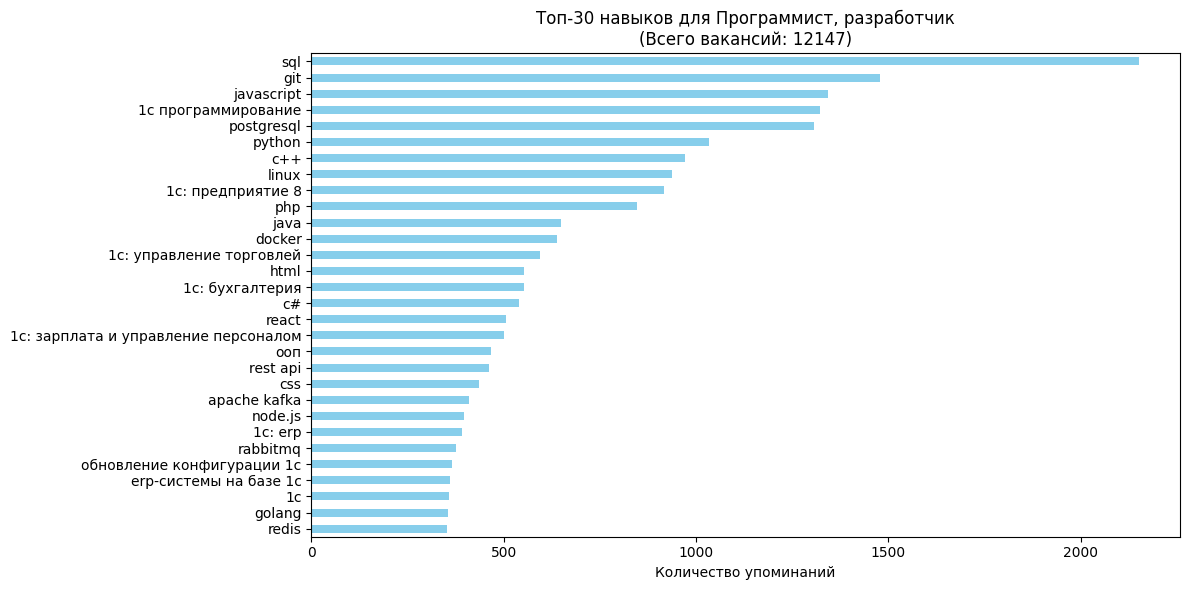

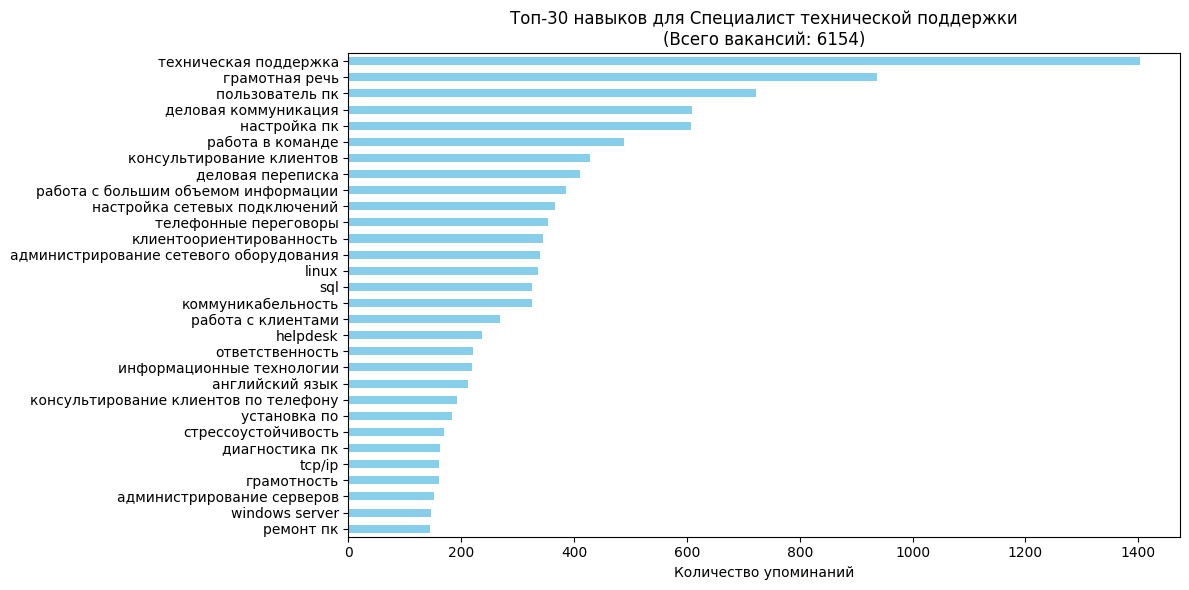

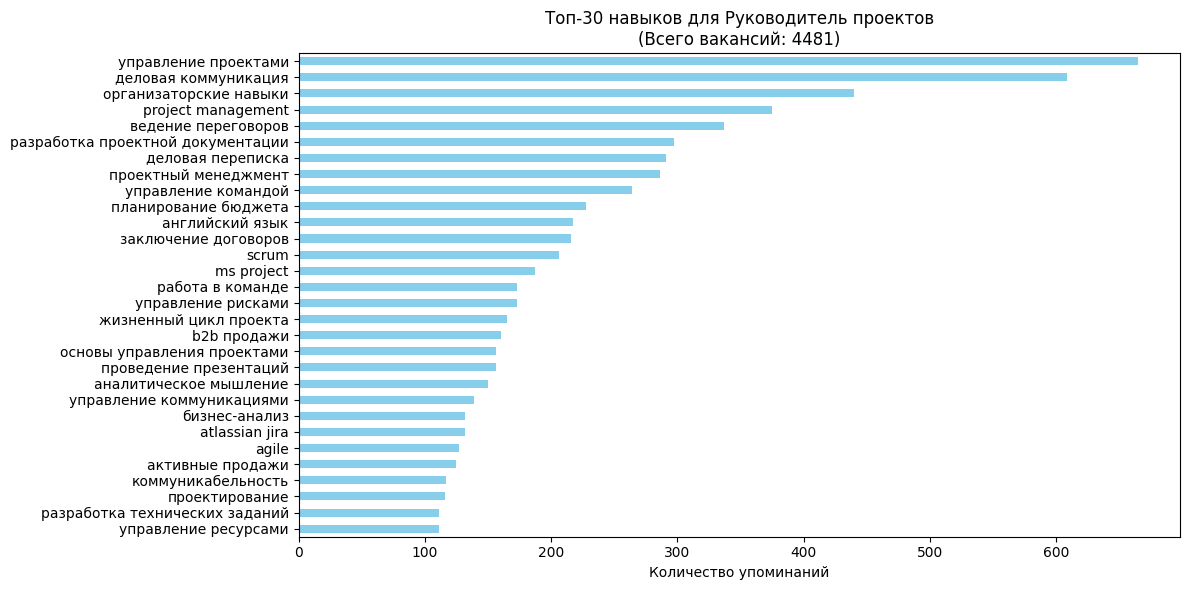

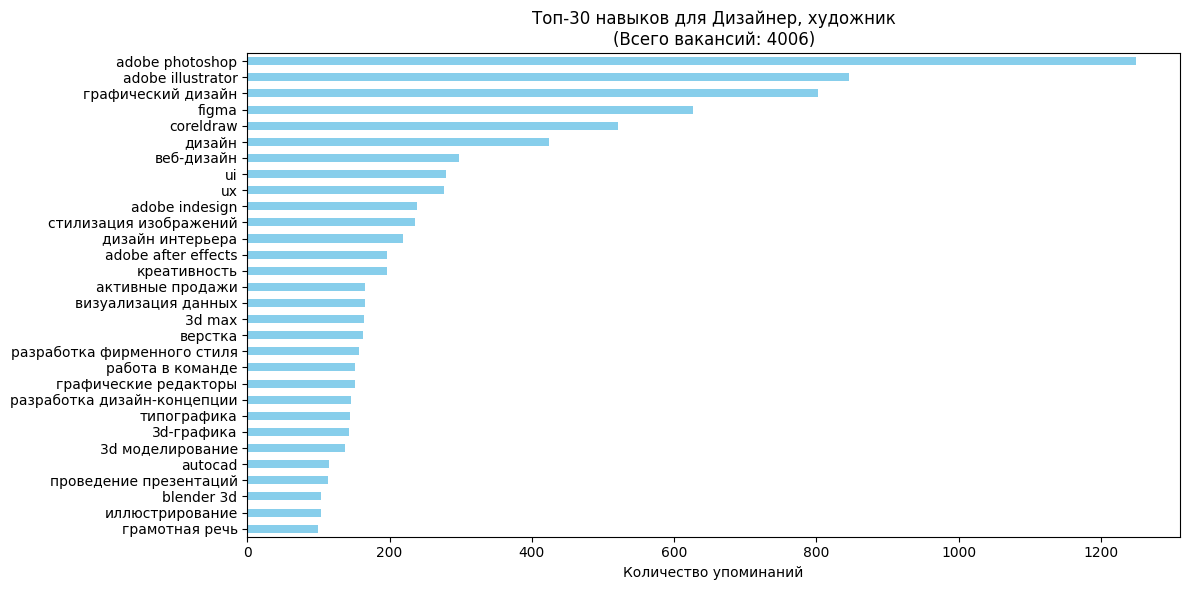

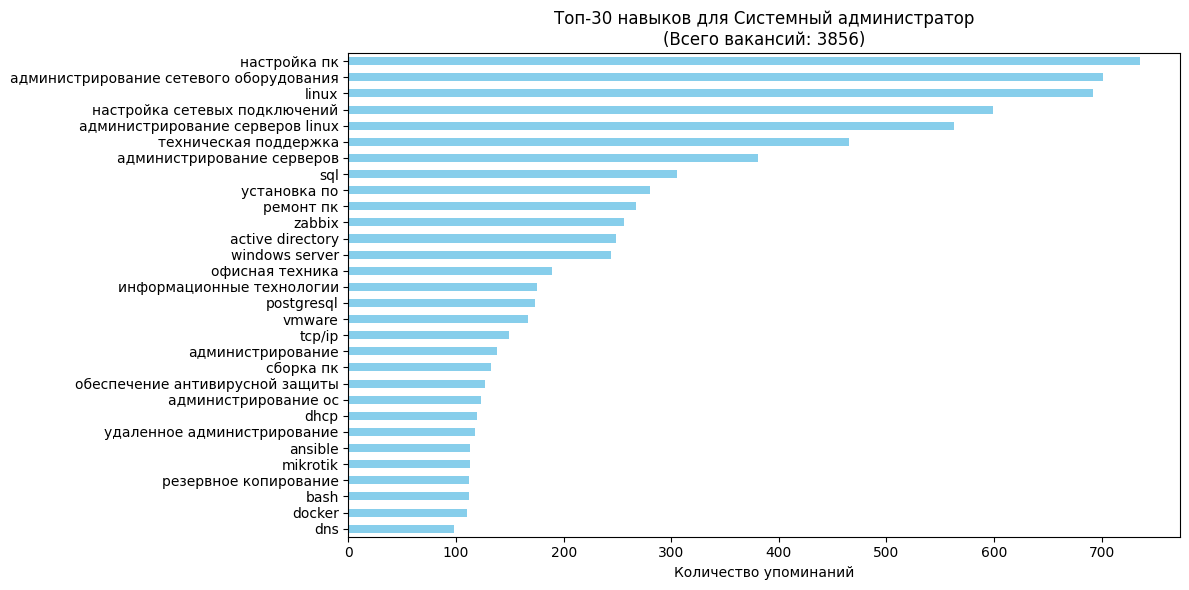

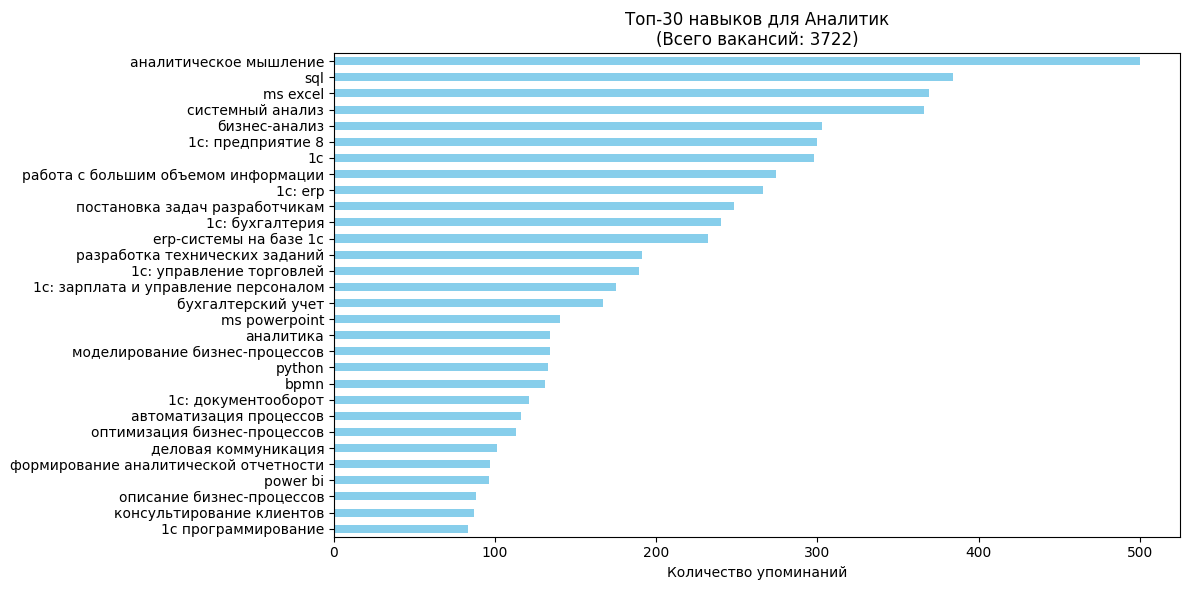

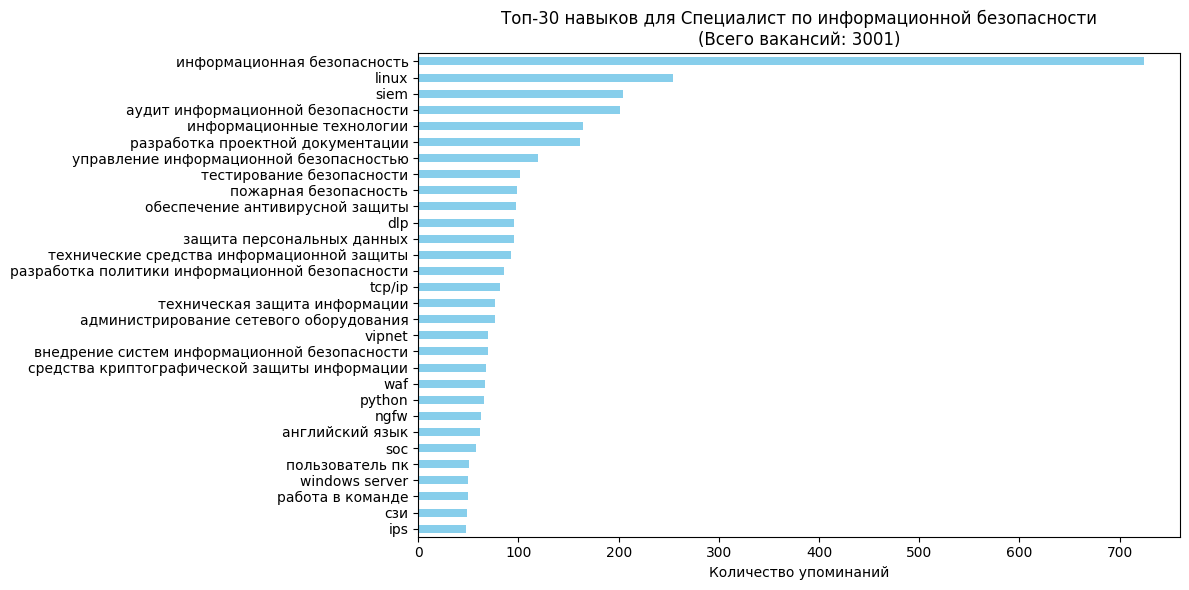

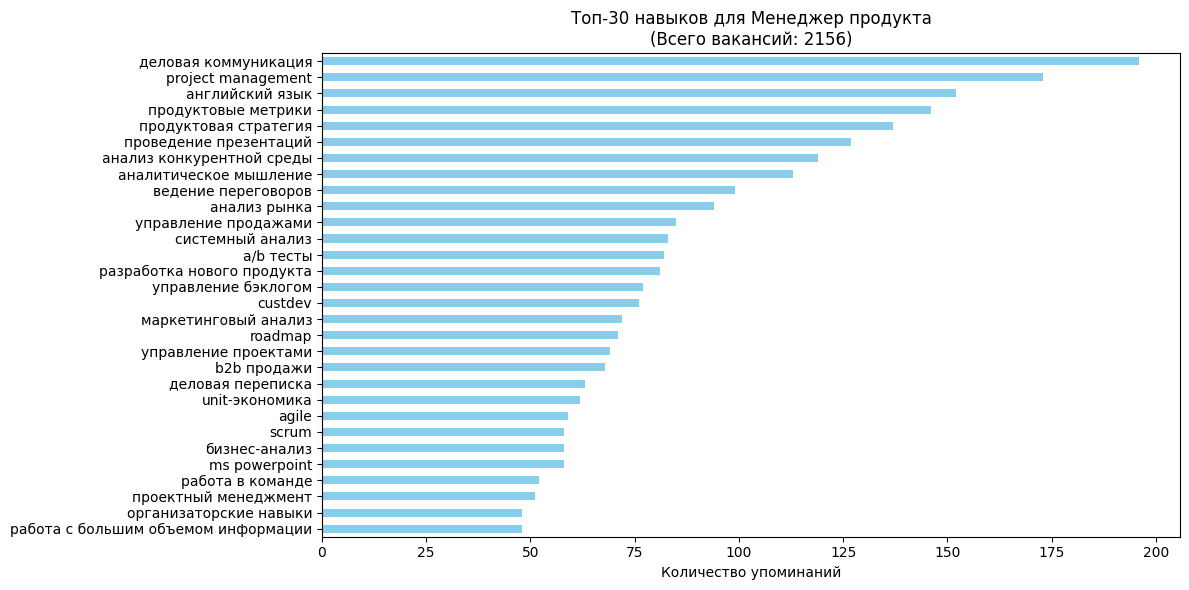

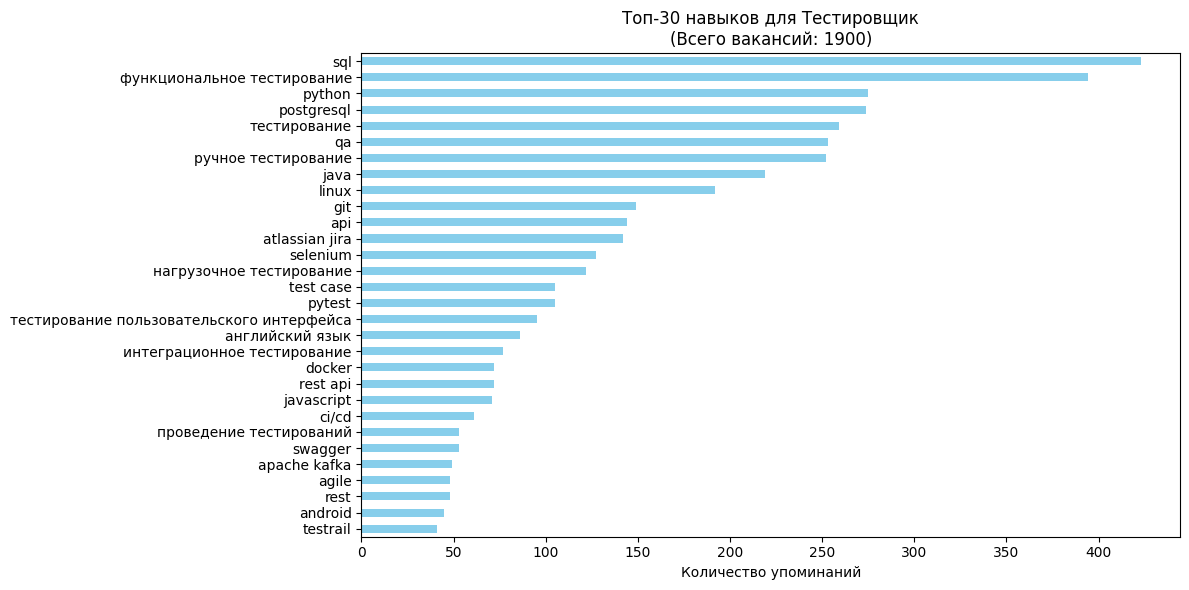

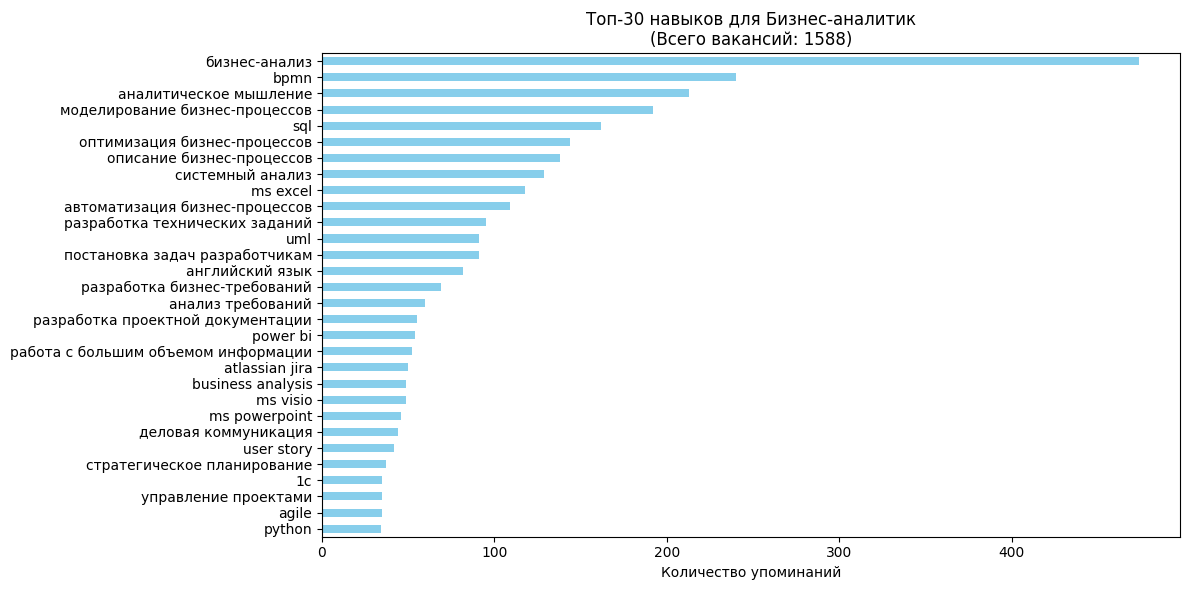

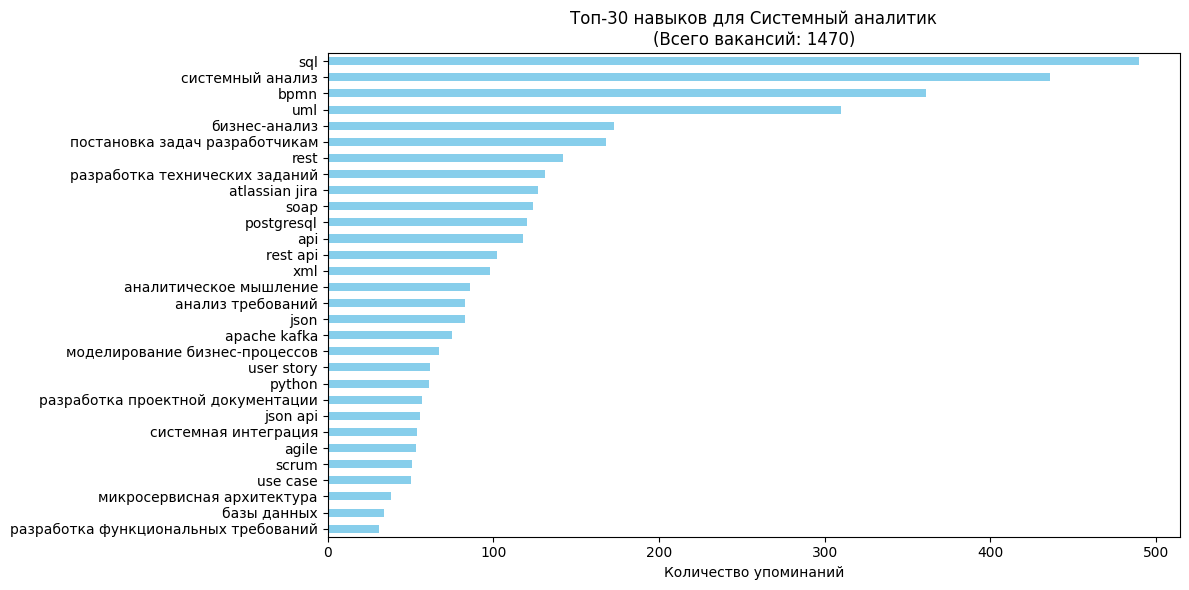

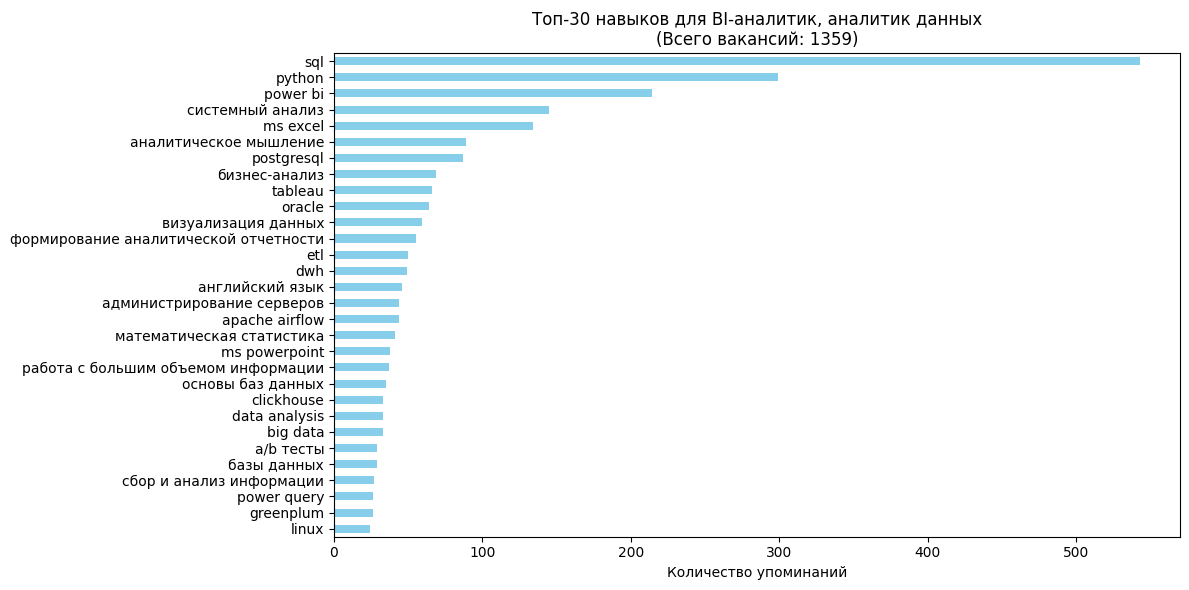

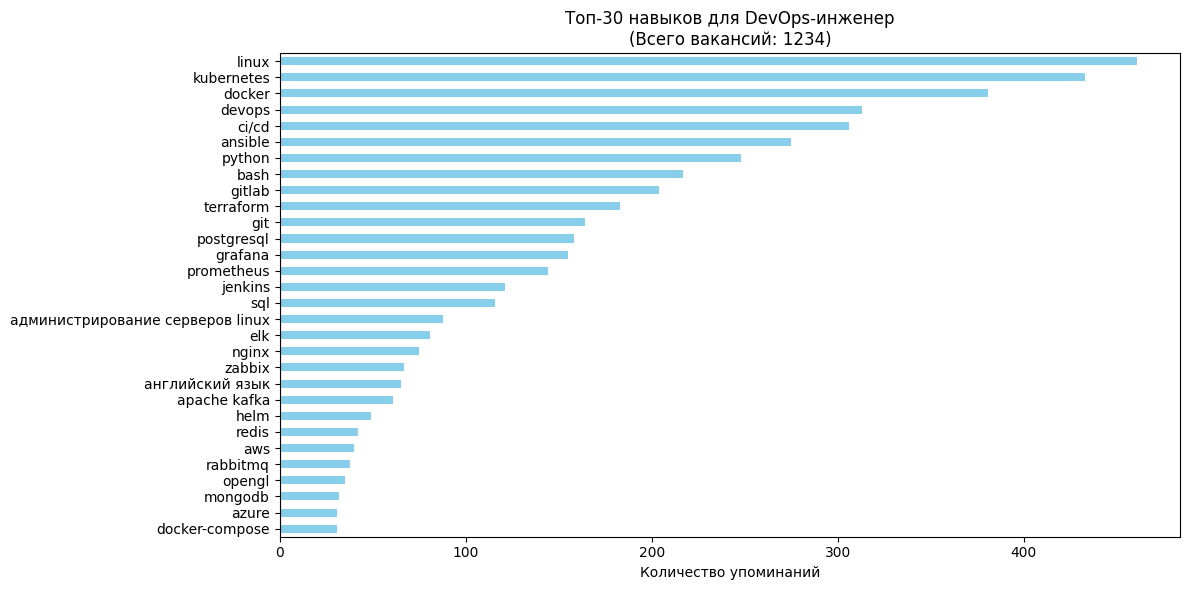

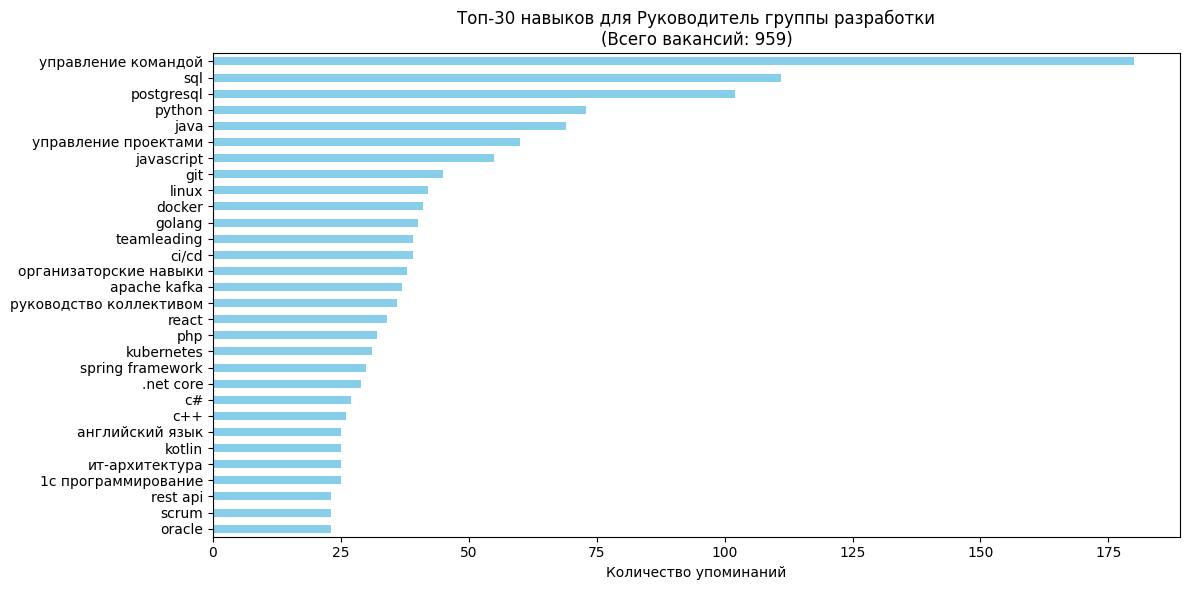

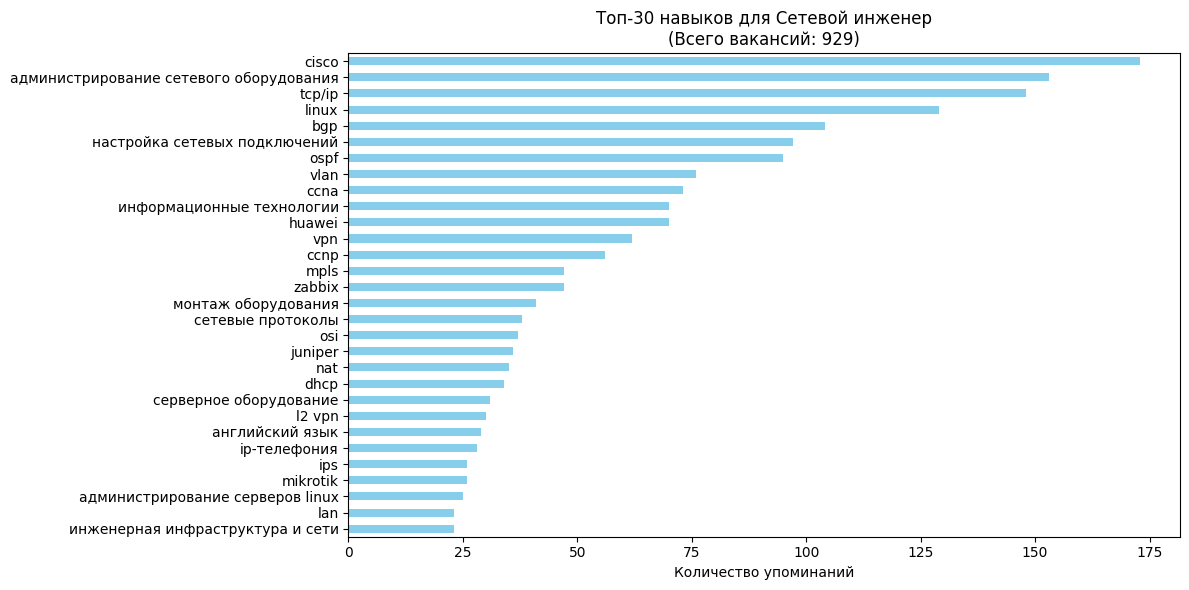

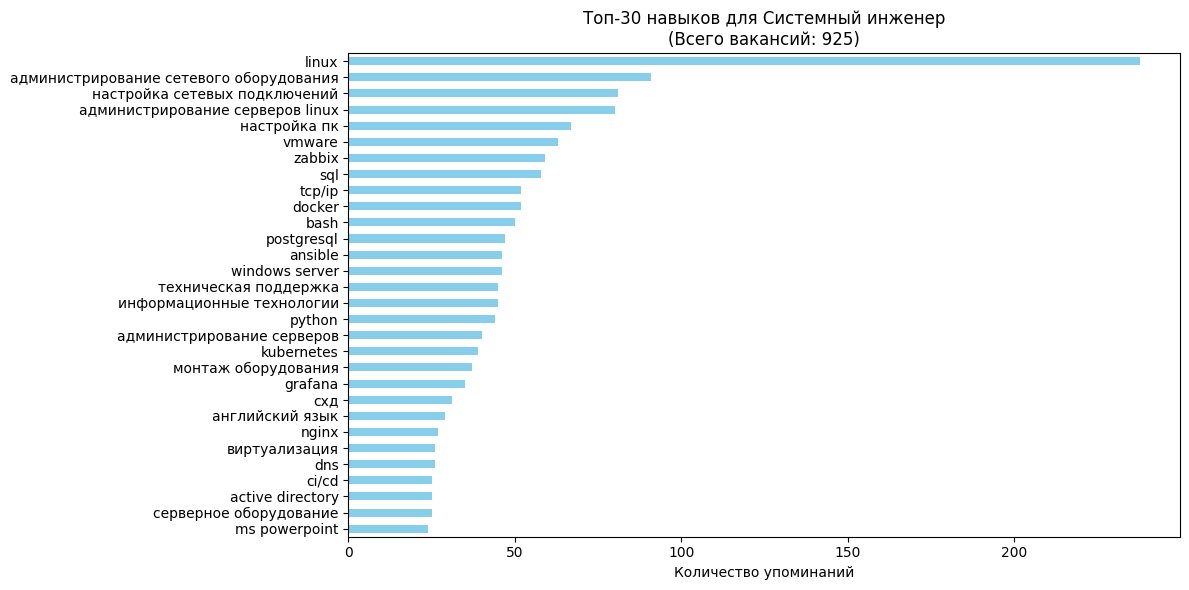

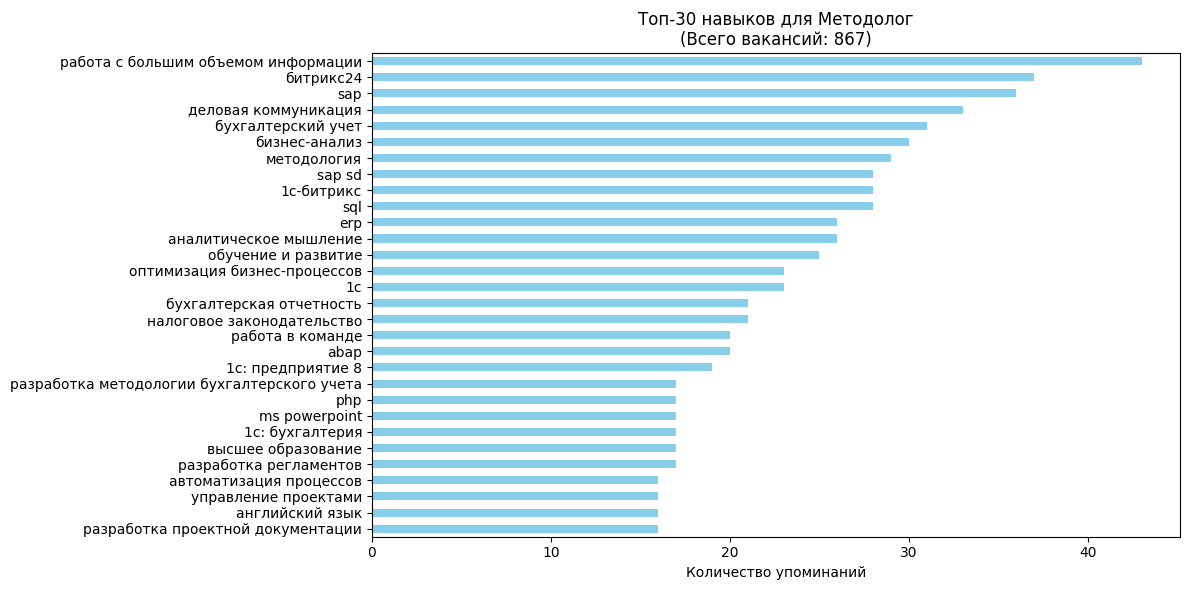

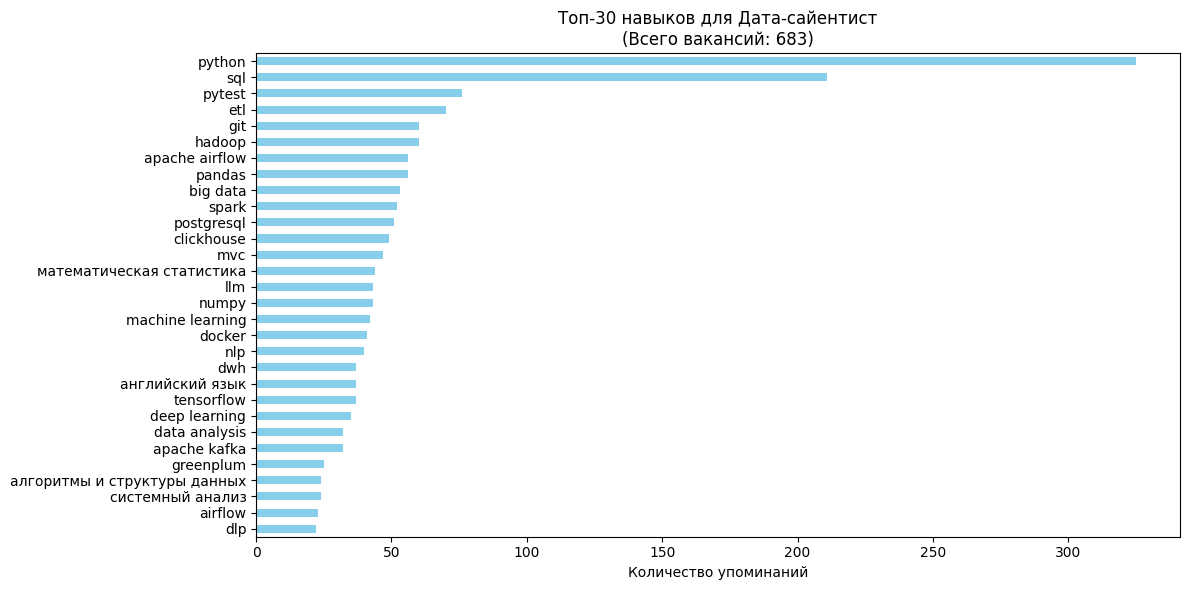

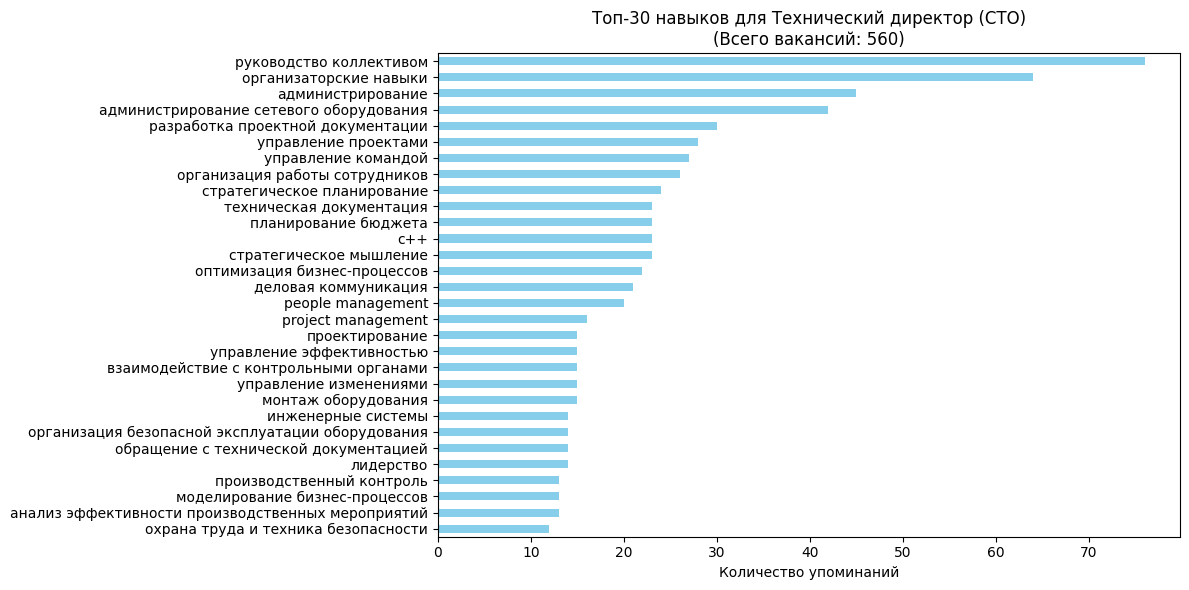

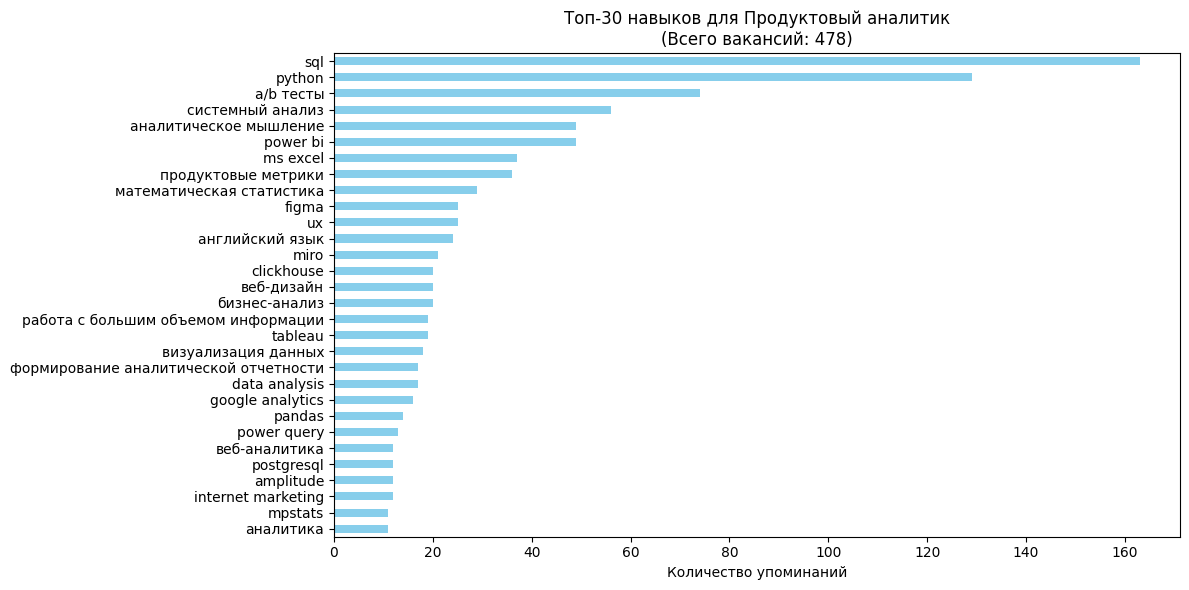

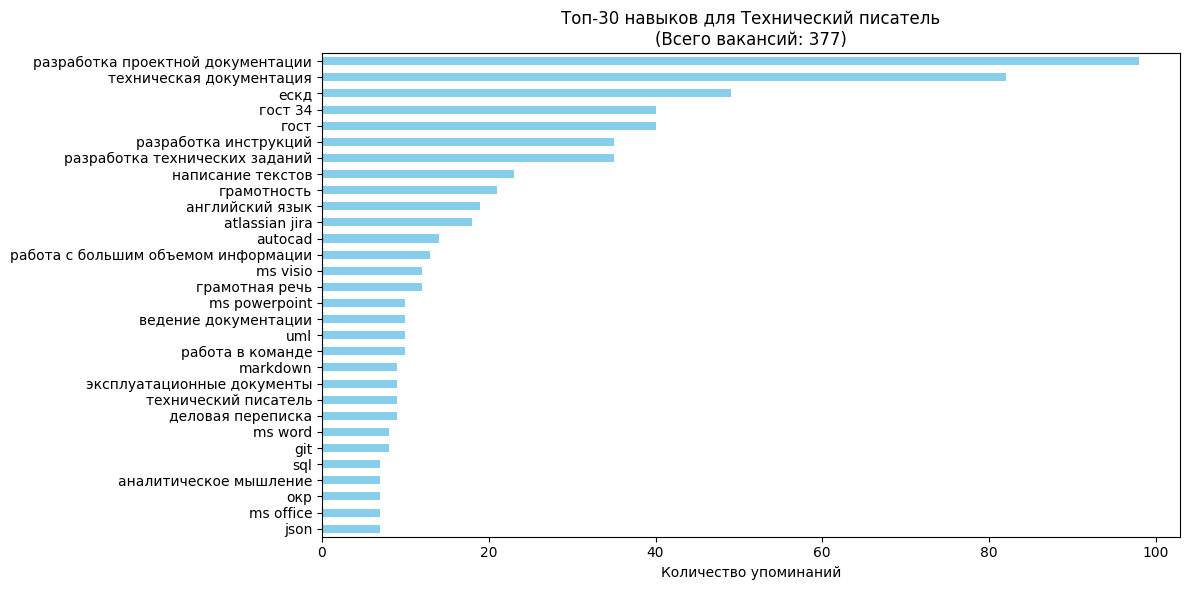

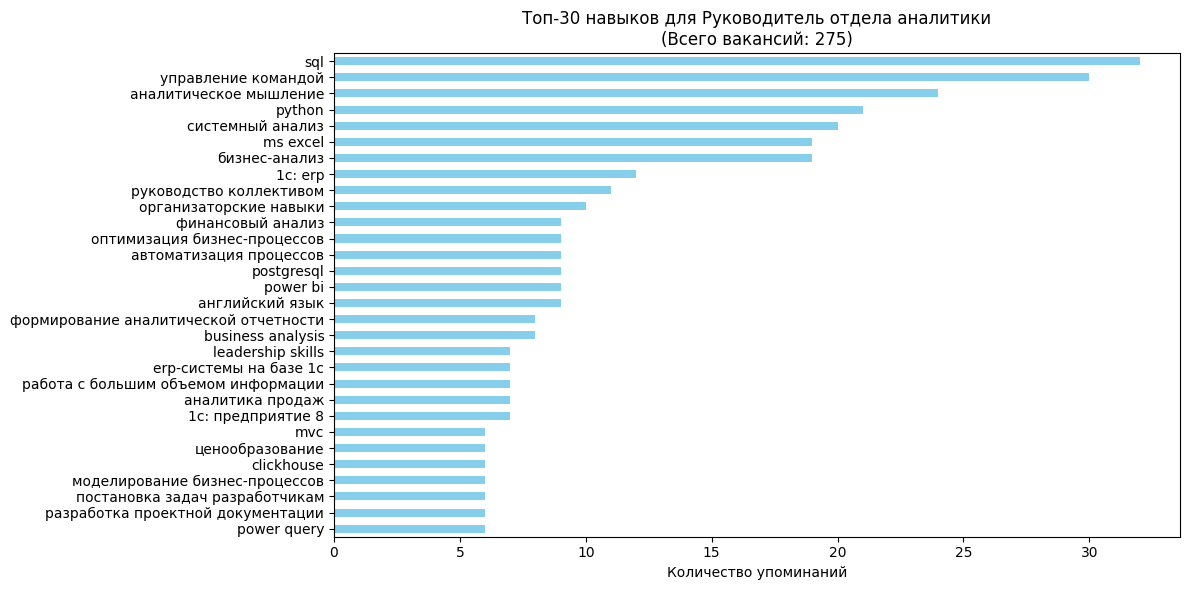

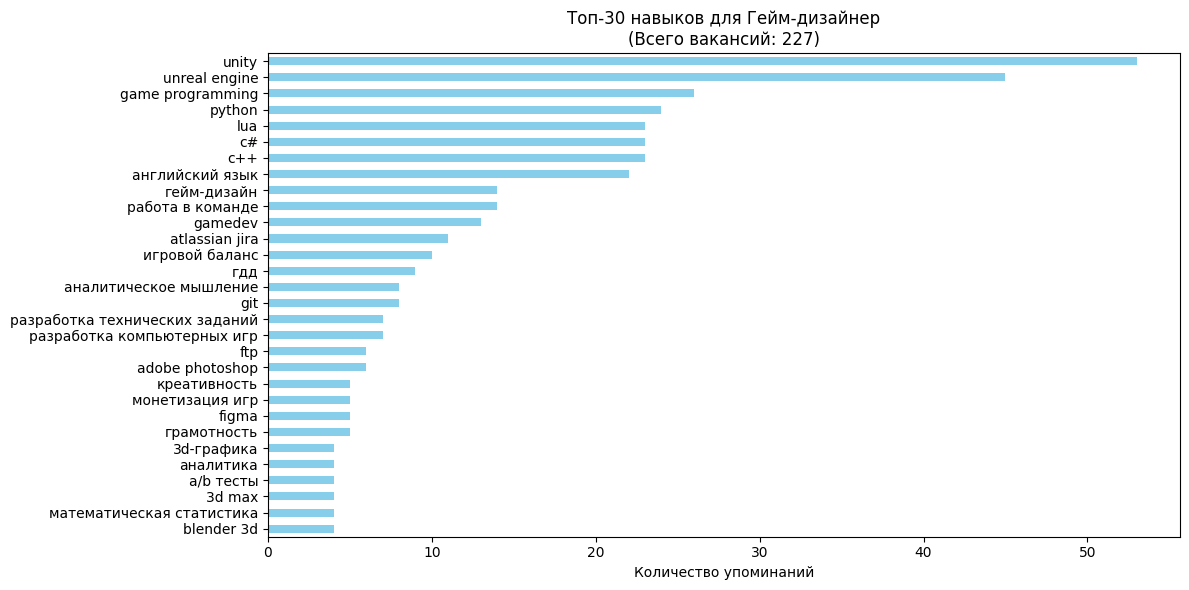

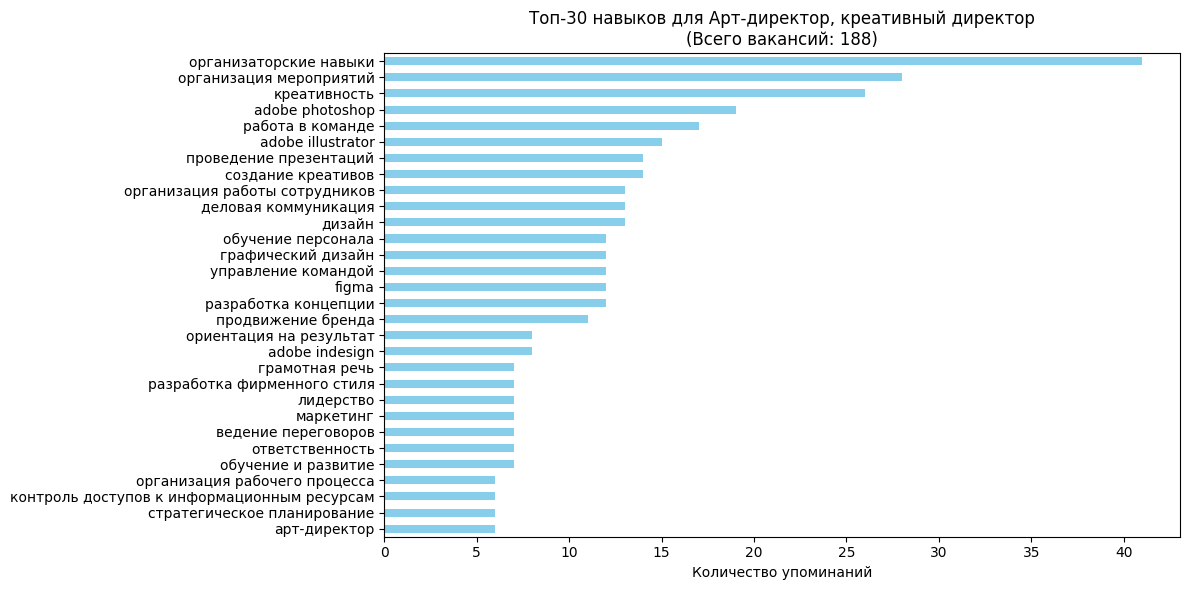

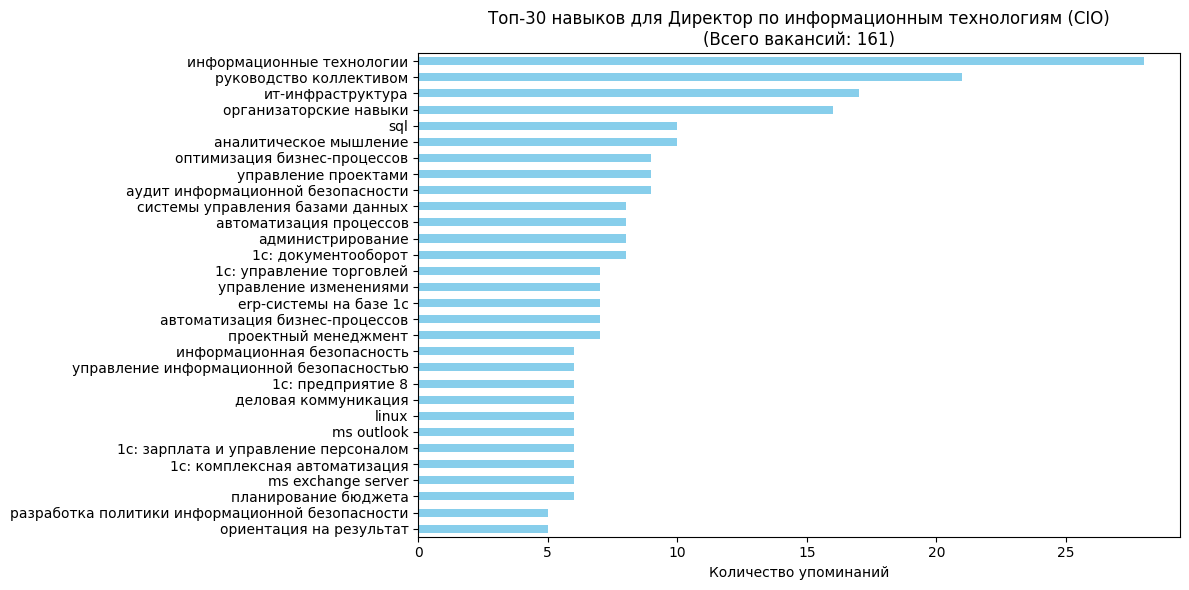

In [ ]:

positions = df['position'].value_counts().index

#Создаем графики для каждой профессии
for position in positions:
    # Фильтруем по профессии и собираем все навыки
    skills_flat = [skill for sublist in df[df['position'] == position]['skills_clean_cl2'] for skill in sublist]
    
    if not skills_flat:
        continue
        
    # Считаем частоту навыков
    skills_counts = pd.Series(skills_flat).value_counts().head(30)
    
    # Создаем график
    plt.figure(figsize=(12, 6))
    skills_counts.sort_values().plot(kind='barh', color='skyblue')
    plt.title(f'Топ-30 навыков для {position}\n(Всего вакансий: {len(df[df["position"]==position])})')
    plt.xlabel('Количество упоминаний')
    plt.tight_layout()
    plt.show()

In [ ]:
# Собираем все скиллы в один список
all_skills = [skill for sublist in df["skills_clean_cl2"] for skill in sublist]
# Считаем частоты всех скиллов
skill_counter = Counter(all_skills)

# Фильтруем по тем, что содержат '1с' или '1c'
filtered = {k: v for k, v in skill_counter.items() if "1с" in k or "1c" in k}

# Сортируем по убыванию
filtered_sorted = dict(sorted(filtered.items(), key=lambda item: item[1], reverse=True))

# Вывод
print("Навыки, содержащие '1с' или '1c':")
for skill, count in filtered_sorted.items():
    print(f"{skill}: {count}")

# Общая сумма
total = sum(filtered_sorted.values())
print(f"\nОбщее количество упоминаний скиллов с '1с' или '1c': {total}")

Навыки, содержащие '1с' или '1c':
1с: предприятие 8: 1563
1с программирование: 1546
1с: бухгалтерия: 955
1с: управление торговлей: 951
1c: erp: 818
1с: зарплата и управление персоналом: 788
erp-системы на базе 1с: 780
1с: 647
1с: документооборот: 560
обновление конфигурации 1с: 455
1с-битрикс: 300
1с: комплексная автоматизация: 246
1с: торговля и склад: 212
создание конфигурации 1с: 184
1с: розница: 123
1с: управление холдингом: 104
1c: 57
1с:ух: 41
1с: зуп: 39
1с: усн: 37
1с: унф: 37
знание 1с: 35
1с 8.3: 27
внедрение 1с: 24
подключение торгового оборудования к 1с: 23
1с ух: 23
1с бгу: 21
программист 1с: 20
администрирование 1с: 20
консультант 1с: 19
сопровождение 1с: 18
аналитик 1с: 15
1с ка: 14
1c: финансы: 13
1с:erpух: 13
1с:медицина: 12
1c: зуп: 12
1с зуп корп 3.1: 11
1с: crm проф: 9
1с: предприятие: управление строительной организацией: 8
1с-рарус: 8
1с: логистика: 7
1с: ут: 7
сертификат 1с: 7
1с:wms: 6
взаимодействие с разработчиками 1с: 6
развитие 1с erp: 6
язык программировани

In [ ]:
def replace_1c_cluster(skills):
    updated = []
    for skill in skills:
        s = skill.lower()
        if s in skills_to_merge:
            updated.append("1с")
        else:
            updated.append(skill)
    return list(set(updated))  # Убираем дубликаты

In [ ]:
df["skills_clean_cl2"] = df["skills_clean_cl2"].apply(replace_1c_cluster)

In [ ]:

# Отдельно фильтруем по содержащим "1с" (русская) или "1c" (английская)
skills_1c = {k: v for k, v in skill_counter.items() if "1с" in k or "1c" in k}

# Делим по порогу
skills_to_merge = {k for k, v in skills_1c.items() if v < 57}
skills_to_keep = {k: v for k, v in skills_1c.items() if v >= 57}

# Объединяем всё, что нужно, под одним "каноном"
merged_counter = {}
merged_counter["1с"] = sum(skill_counter[k] for k in skills_to_merge)
merged_counter.update(skills_to_keep)

# Вывод
for skill, count in sorted(merged_counter.items(), key=lambda x: x[1], reverse=True):
    print(f"{skill}: {count}")

print(f"\nОбщее количество упоминаний по всем 1с-навыкам: {sum(merged_counter.values())}")

1с: предприятие 8: 1563
1с программирование: 1546
1с: бухгалтерия: 955
1с: управление торговлей: 951
1c: erp: 818
1с: зарплата и управление персоналом: 788
erp-системы на базе 1с: 780
1с: 647
1с: документооборот: 560
обновление конфигурации 1с: 455
1с-битрикс: 300
1с: комплексная автоматизация: 246
1с: торговля и склад: 212
создание конфигурации 1с: 184
1с: розница: 123
1с: управление холдингом: 104
1c: 57

Общее количество упоминаний по всем 1с-навыкам: 10289


In [ ]:

# Словарь для хранения топ-80 скиллов по каждой позиции
top_skills_dict = {}

positions = df['position'].value_counts().index

for position in positions:
    # Извлекаем навыки
    skills_flat = [skill for sublist in df[df['position'] == position]['skills_clean_cl2'] for skill in sublist]

    if not skills_flat:
        continue

    # Сохраняем топ-80 навыков
    top_80 = pd.Series(skills_flat).value_counts().head(40).index.tolist()
    top_skills_dict[position] = top_80

# Преобразуем словарь в DataFrame (skills в строках, позиции — колонки)
max_len = max(len(skills) for skills in top_skills_dict.values())
df_top_skills = pd.DataFrame({
    position: skills + [None] * (max_len - len(skills))
    for position, skills in top_skills_dict.items()
})

# Сохраняем в Excel
df_top_skills.to_excel("top_40_skills_by_position.xlsx", index=False)

In [ ]:
all_skills = flatten_skills(df['skills_clean_cl2'])

# 3. Подсчет уникальных навыков
unique_skills_count = len(set(all_skills))

In [ ]:
unique_skills_count

6255

In [ ]:


top40_share_per_position = []

for position in df['position'].unique():
    # Все навыки по позиции (все упоминания)
    skills_flat = [skill for sublist in df[df['position'] == position]['skills_clean_cl2'] for skill in sublist]
    
    if not skills_flat:
        continue
    
    skill_counts = Counter(skills_flat)

    total_mentions = sum(skill_counts.values())            # всего упоминаний
    total_unique_skills = len(skill_counts)                # всего уникальных навыков
    
    top_40 = [skill for skill, _ in skill_counts.most_common(40)]
    top_40_mentions = sum([skill_counts[skill] for skill in top_40])
    
    share_unique = len(top_40) / total_unique_skills * 100
    share_mentions = top_40_mentions / total_mentions * 100
    
    top40_share_per_position.append({
        "position": position,
        "total_unique_skills": total_unique_skills,
        "top_40_count": len(top_40),
        "share_percent": round(share_unique, 2),             # уникальность
        "top_40_coverage_percent": round(share_mentions, 2)  # доля по частоте
    })

df_top40_share = pd.DataFrame(top40_share_per_position)
df_top40_share = df_top40_share.sort_values(by="top_40_coverage_percent", ascending=False)

display(df_top40_share)

,position,total_unique_skills,top_40_count,share_percent,top_40_coverage_percent
1,DevOps-инженер,493,40,8.11,78.94
6,Дата-сайентист,362,40,11.05,70.44
5,Гейм-дизайнер,200,40,20.00,66.98
18,Системный аналитик,642,40,6.23,65.65
22,Тестировщик,706,40,5.67,65.06
12,Продуктовый аналитик,301,40,13.29,64.15
24,Технический писатель,291,40,13.75,64.03
0,"BI-аналитик, аналитик данных",609,40,6.57,63.68
4,Бизнес-аналитик,667,40,6.00,62.61
17,Системный администратор,1065,40,3.76,60.53


In [ ]:
# Параметры
TOP_N = 100

# Хранение результатов
stats = []


for position in positions:
    # Извлекаем все навыки по позиции
    skills_flat = [skill for sublist in df[df['position'] == position]['skills_clean_cl2'] for skill in sublist]

    if not skills_flat:
        continue

    # Подсчёты
    total_count = len(skills_flat)  # общее количество навыков (включая повторы)
    total_unique_skills = len(set(skills_flat))  # уникальные навыки

    skills_series = pd.Series(skills_flat)
    top_skills = skills_series.value_counts().head(TOP_N)

    top_n_coverage = top_skills.sum()  # сколько раз top-N навыки упоминаются
    unique_top_skills = len(top_skills)

    top_n_coverage_percent = round(top_n_coverage / total_count * 100, 2)
    share_percent = round(unique_top_skills / total_unique_skills * 100, 2)

    stats.append({
        'position': position,
        'total_unique_skills': total_unique_skills,
        'unique_top_skills': unique_top_skills,
        #'top_n_coverage': top_n_coverage,
        #'total_count': total_count,
        'top_100_coverage_percent': top_n_coverage_percent,
        
        
        'share_percent': share_percent
    })

# В DataFrame
df_stats = pd.DataFrame(stats)

# Сохраняем
output_path = "top100_skills_stats_by_position.xlsx"
df_stats.to_excel(output_path, index=False)

In [ ]:
display(df_stats)

,position,total_unique_skills,unique_top_skills,top_100_coverage_percent,share_percent
0,"Программист, разработчик",2494,100,68.78,4.01
1,Специалист технической поддержки,1440,100,75.40,6.94
2,Руководитель проектов,1554,100,68.19,6.44
3,"Дизайнер, художник",1065,100,78.53,9.39
4,Системный администратор,1065,100,78.05,9.39
5,Аналитик,1128,100,72.97,8.87
6,Специалист по информационной безопасности,1113,100,65.59,8.98
7,Менеджер продукта,1065,100,66.31,9.39
8,Тестировщик,706,100,81.55,14.16
9,Бизнес-аналитик,667,100,77.81,14.99
